### FINM33150 - Quant Trading Strategies
## Homework 7
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: May 20th, 2021

Full disclosure, when I read the assignment my understanding of the instructions was to compute a multi factor beta regression. This was the result from asking to compute $\beta_t^{i,t} \; \forall t,i,\lambda$. It was only after Tuesday's lecture that my understanding of the task at hand was slightly different than the one I interpreted. While I am tackling a slightly different problem, my belief is that I addressed similar issues at hand in a way that is both valuable and interesting both from a practical and theoretical aspect. My hope is that you will feel the same after reading through my analysis and methodology. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import pickle
import quandl
import functools
import os
from tqdm import tqdm
import copy
from sklearn import linear_model as lm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

quandl_key = os.environ.get('QUANDL_API_KEY') # Works now, might need to reset env or computer to have it work 

In [2]:
plt.style.use('seaborn-bright')

%matplotlib inline
pd.set_option("precision", 6)

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# 1. Data

In [5]:
# List tickers on Quandl
tickers_df = pd.read_csv("ticker_list.csv")
tickers_list = random.sample(list(tickers_df['Ticker']), 800)
tickers_list.append("SPY")

In [6]:
len(tickers_list)

801

In [7]:
qdl_data = {}
START_DATE  = '2016-01-01'
END_DATE = '2020-12-31'
error_counts = 0
for ticker in tqdm(tickers_list):
    try:
        # Was getting some weird result with this ticker in the dataset
        if ticker == 'SVM':
            continue
        qdl_data[ticker] = quandl.get('EOD/'+ticker + ".11",start_date = START_DATE, end_date = END_DATE, api_key = quandl_key)
        qdl_data[ticker].columns = [ticker]
    except ValueError as e:
        error_counts += 1
print(f"Number of errors grabbing data from QuandlAPI: {error_counts}")


100%|████████████████████████████████████████████████████████████████████████████████| 801/801 [05:06<00:00,  2.61it/s]

Number of errors grabbing data from QuandlAPI: 73


In [8]:
tickers_data = pd.concat(qdl_data.values(), axis = 1)
tickers_data.dropna(axis=1, inplace = True)
tickers_data = tickers_data.apply(np.log).diff().iloc[1:]
tickers_data.head()
tickers_data.to_pickle("qdl_df.pickle")

In [9]:
tickers_data = pd.read_pickle("qdl_df.pickle")

In [10]:
print("SPY" in tickers_data.columns)
print(tickers_data.isnull().sum().sum())

True
0


# 2. Exponentially Weighted Regressions

Adding a bunch of columns to our dataframe for analysis later and keeping track of the factors{columns} for convenience.

In [11]:
regression_factors = tickers_data.columns[:-1]
beta_exp_factors = []
beta_box_factors = []
target_factors = []
time_factors = []

exp_pred_factors = []
box_pred_factors = []
time_pred_factors = []

for col in regression_factors:
    tickers_data["{}_exp_coeff".format(col)] = 0
    tickers_data["{}_box_coeff".format(col)] = 0  
    tickers_data["{}_target_coeff".format(col)] = 0  
    tickers_data["{}_time_coeff".format(col)] = 0  
    beta_exp_factors.append("{}_exp_coeff".format(col))
    beta_box_factors.append("{}_box_coeff".format(col))
    target_factors.append("{}_target_coeff".format(col))
    time_factors.append("{}_time_coeff".format(col))
    
for i in range(1,6):
    tickers_data['exp_pred_{}'.format(i)] = 0
    tickers_data['box_pred_{}'.format(i)] = 0    
    tickers_data['time_pred_{}'.format(i)] = 0    
    exp_pred_factors.append('exp_pred_{}'.format(i))
    box_pred_factors.append('box_pred_{}'.format(i))
    time_pred_factors.append('time_pred_{}'.format(i))


tickers_data['spy_1_day_fwd'] = tickers_data['SPY'].shift(-1)
tickers_data['spy_2_day_fwd'] = tickers_data['SPY'].shift(-2)
tickers_data['spy_3_day_fwd'] = tickers_data['SPY'].shift(-3)
tickers_data['spy_4_day_fwd'] = tickers_data['SPY'].shift(-4)
tickers_data['spy_5_day_fwd'] = tickers_data['SPY'].shift(-5)

fwd_pred_factors = ['spy_{}_day_fwd'.format(i) for i in range (1,6)] 

# 2. Exponentially Weighted Regressions

In [12]:
def ols_coefficients(df, decay_coef):
    for i in tqdm(range(2,len(df.index)-6)):
        date = df.index[i]
        model = lm.LinearRegression()
        
        # Normal EXPONENTIAL REGRESSION
        X_exp = df[regression_factors].iloc[:i+1]
        y_exp = df['SPY'].iloc[:i+1]
        X_test = df[regression_factors].iloc[i+1:i+6]
        
        exp_weights = np.ones(i+1) * (1-decay_coef) **np.arange(i+1)
        res1 = model.fit(X_exp, y_exp, sample_weight = exp_weights)
        
        df.loc[date,beta_exp_factors] = res1.coef_
        df.loc[date, exp_pred_factors] = res1.predict(X_test)

        
        # TIME EXPONENTIAL
        exp_weights2 = np.exp(-decay_coef*np.arange(i+1))
        res2 = model.fit(X_exp, y_exp, sample_weight = exp_weights2)
        
        df.loc[date,time_factors] = res2.coef_
        df.loc[date, time_pred_factors] = res2.predict(X_test)

        # BOX CAR REGRESSION
        if i >= 2/decay_coef:
            X_box = df[regression_factors].iloc[i+1-int((2/decay_coef)):i+1]
            y_box = df['SPY'].iloc[i+1-int((2/decay_coef)):i+1]
            box_weights = np.ones(int(2/decay_coef))/(2/decay_coef)
            
            res3 = model.fit(X_box, y_box, sample_weight = box_weights)
            df.loc[date,beta_box_factors] = res3.coef_
            df.loc[date, box_pred_factors] = res3.predict(X_test)
        
        # TARGET REGRESSION OOS
        X_tar = df[regression_factors].iloc[i+1:i+6]
        y_tar = df['SPY'].iloc[i+1:i+6]
        tar_weights = np.ones(5)/5
        
        res4 = model.fit(X_tar, y_tar, sample_weight = tar_weights)
        df.loc[date,target_factors] = res4.coef_
    
    # Clears some garbage data at the ends. 
    return df[int(2/decay_coef)+5:len(df.index)-10].dropna()


In [13]:
decay_fac = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25]
master_df = []
for decay in decay_fac:
    df = ols_coefficients(tickers_data, decay)
    df.to_pickle('df_decay_{}'.format(decay))
    master_df.append(df)

100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [04:17<00:00,  4.85it/s]


# 3. Analysis

In [14]:
def plot_r2_score_cumsum(mae_ = False):
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    if mae_:
        title = "MAE"
    else:
        title = "R2"
    plt.suptitle("Cumulative {} score of Different Weighted Regression Types".format(title), fontsize = 20)
    
    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3
        df = master_df[i]
        decay = decay_fac[i]
        df1 = df[beta_exp_factors]
        df2 = df[target_factors]
        df3 = df[time_factors]
        df4 = df[beta_box_factors] 
        
        df2['exp_coeffs_mae'] = 0 
        df2['time_coeffs_mae'] = 0 
        df2['box_coeffs_mae'] = 0 
        df2['exp_coeffs_r2'] = 0 
        df2['time_coeffs_r2'] = 0 
        df2['box_coeffs_r2'] = 0 

        for i in range(len(df1.columns)):
            df2['exp_coeffs_mae'] += abs(df1[df1.columns[i]] - df2[df2.columns[i]])
            df2['time_coeffs_mae'] += abs(df3[df3.columns[i]] - df2[df2.columns[i]])
            df2['box_coeffs_mae'] += abs(df4[df4.columns[i]] - df2[df2.columns[i]])
            df2['exp_coeffs_r2'] += r2_score(df2[df2.columns[i]], df1[df1.columns[i]],multioutput='variance_weighted')
            df2['time_coeffs_r2'] += r2_score(df2[df2.columns[i]], df3[df3.columns[i]],multioutput='variance_weighted')
            df2['box_coeffs_r2'] += r2_score(df2[df2.columns[i]], df4[df4.columns[i]],multioutput='variance_weighted')
        if mae_:
            axes[k,j].plot((df2[['exp_coeffs_mae','time_coeffs_mae','box_coeffs_mae']]/len(df2.columns)).cumsum())
            axes[k,j].set_title("Cumulative MAE score of the Regression coefficients with Decay rate of {} for exponential".format(decay))
            axes[k,j].legend(['exp_coeffs_mae','time_coeffs_mae','box_coeffs_mae'],fontsize=14)
            axes[k,j].set_xlabel("DATE")
            axes[k,j].set_ylabel("MAE")
        else:
            axes[k,j].plot((df2[['exp_coeffs_r2','time_coeffs_r2','box_coeffs_r2']]/len(df2.columns)).cumsum())
            axes[k,j].set_title("Cumulative R2 score of the Regression coefficients with Decay rate of {} for exponential".format(decay))
            axes[k,j].legend(['exp_coeffs_r2','time_coeffs_r2','box_coeffs_r2'],fontsize=14)
            axes[k,j].set_xlabel("DATE")
            axes[k,j].set_ylabel("R2")
            axes[k,j].set_yscale('symlog')



In [15]:
def plot_coefs_change_sum():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("Daily Absolute Mean Coefficients Percentage Change of Different Weighted Regression Types", fontsize = 20)
    
    regress_types = "Exponential Time-Expo Box Target".split()
    col_names1 = [reg+"-"+ str(decay_fac[i]) for i in range(3) for reg in regress_types]
    col_names2 = [reg+"-"+ str(decay_fac[i]) for i in range(3,6) for reg in regress_types]

    stats1 = pd.DataFrame(data = None, columns = col_names1, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
    stats2 = pd.DataFrame(data = None, columns = col_names2, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])

    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df1 = df[beta_exp_factors]
        df2 = df[target_factors]
        df3 = df[time_factors]
        df4 = df[beta_box_factors]
        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]

        # We are removing the outliers from the box regressions since we get blocks where the values blow up while keeping enough data that explains the narrative
        df1 = df1.pct_change()[1:].fillna(0).iloc[np.where(abs(df1.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df2 = df2.pct_change()[1:].fillna(0).iloc[np.where(abs(df2.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df3 = df3.pct_change()[1:].fillna(0).iloc[np.where(abs(df3.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df4 = df4.pct_change()[1:].fillna(0).iloc[np.where(abs(df4.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        
        dfs = [df1.mean(axis=1).abs(),df3.mean(axis=1).abs(),df4.mean(axis=1).abs(),df2.mean(axis=1).abs()]
        for n in range(4):
            data = dfs[n]
            if k == 0:
                stats1[col_names1[4*j+n]].loc['Mean'] = data.mean()
                stats1[col_names1[4*j+n]].loc['Median'] = data.median()
                stats1[col_names1[4*j+n]].loc['Std Dev'] = data.std()
                stats1[col_names1[4*j+n]].loc['1st Quartile'] = data.quantile(0.25)
                stats1[col_names1[4*j+n]].loc['3rd Quartile'] = data.quantile(0.75)
                stats1[col_names1[4*j+n]].loc['Skew'] = sp.stats.skew(data.dropna())
                stats1[col_names1[4*j+n]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
            else:
                stats2[col_names2[4*j+n]].loc['Mean'] = data.mean()
                stats2[col_names2[4*j+n]].loc['Median'] = data.median()
                stats2[col_names2[4*j+n]].loc['Std Dev'] = data.std()
                stats2[col_names2[4*j+n]].loc['1st Quartile'] = data.quantile(0.25)
                stats2[col_names2[4*j+n]].loc['3rd Quartile'] = data.quantile(0.75)
                stats2[col_names2[4*j+n]].loc['Skew'] = sp.stats.skew(data.dropna())
                stats2[col_names2[4*j+n]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
                
                
        axes[k,j].plot(df1.mean(axis=1).abs(),  color = 'navy', label = 'exp')
        axes[k,j].plot(df3.mean(axis=1).abs(),  color = 'cyan', label = 'time exp')
        axes[k,j].plot(df4.mean(axis=1).abs(), color = 'orange', label = 'box')
        axes[k,j].plot(df2.mean(axis=1).abs(), color = 'red', label = 'target box')
        axes[k,j].set_title("Daily Mean Percentage Change when Decay Rate = {}".format(decay))
        axes[k,j].legend(fontsize=14)
        axes[k,j].set_xlabel("DATE")
        axes[k,j].set_ylabel("Daily Change")
    
    plt.show()
    return stats1, stats2


In [16]:
def plot_coefs_change_cumsum():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("Cumulative Absolute Mean Coefficients Percentage Change of Different Weighted Regression Types", fontsize = 20)

    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df1 = df[beta_exp_factors]
        df2 = df[target_factors]
        df3 = df[time_factors]
        df4 = df[beta_box_factors]


        # We are removing the outliers from the box regressions since we get blocks where the values blow up while keeping enough data that explains the narrative
        df1 = df1.pct_change()[1:].fillna(0).iloc[np.where(abs(df1.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df2 = df2.pct_change()[1:].fillna(0).iloc[np.where(abs(df2.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df3 = df3.pct_change()[1:].fillna(0).iloc[np.where(abs(df3.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        df4 = df4.pct_change()[1:].fillna(0).iloc[np.where(abs(df4.pct_change()[1:].fillna(0)).mean(axis=1) <500)[0]]
        

        axes[k,j].plot(df1.mean(axis=1).abs().cumsum(),  color = 'navy', label = 'exp')
        axes[k,j].plot(df3.mean(axis=1).abs().cumsum(),  color = 'cyan', label = 'time exp')
        axes[k,j].plot(df4.mean(axis=1).abs().cumsum(), color = 'orange', label = 'box')
        axes[k,j].plot(df2.mean(axis=1).abs().cumsum(), color = 'red', label = 'target box')
        axes[k,j].set_title("Cumulative Mean Percentage Change when Decay Rate = {}".format(decay))
        axes[k,j].legend(fontsize=14)
        axes[k,j].set_xlabel("DATE")
        axes[k,j].set_ylabel("Cumulative Change")
        
    plt.show()


In [17]:
def plot_prediction():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("Daily Sum of up to 5 days SPY prediction Different Weighted Regression Types", fontsize = 20)

    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]

       
        axes[k,j].plot(df5.sum(axis=1),label = 'exp')
        axes[k,j].plot(df6.sum(axis=1),label = 'box')
        axes[k,j].plot(df7.sum(axis=1), label = 'time exp')
        axes[k,j].plot(df8.sum(axis=1), label = 'SPY')
        axes[k,j].set_title("Daily 5 day predictions sum when Decay Rate = {}".format(decay))
        axes[k,j].legend(fontsize=14)
        axes[k,j].set_xlabel("DATE")
        axes[k,j].set_ylabel("Daily Return")
        
    plt.show()


In [18]:
def plot_abs_spread_prediction():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("Daily Absolute Sum of the Spread with SPY of up to 5 days for Different Weighted Regression Types", fontsize = 20)

    regress_types = "Exponential Time-Expo Box".split()
    col_names1 = [reg+"-"+ str(decay_fac[i]) for i in range(3) for reg in regress_types]
    col_names2 = [reg+"-"+ str(decay_fac[i]) for i in range(3,6) for reg in regress_types]

    stats1 = pd.DataFrame(data = None, columns = col_names1, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
    stats2 = pd.DataFrame(data = None, columns = col_names2, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])

    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
            
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]
        
        dfs = [df5,df7,df6]
        
        for n in range(3):
            data = abs(df8.values-dfs[n].values).sum(axis=1)
            if k == 0:
                stats1[col_names1[3*j+n]].loc['Mean'] = data.mean()
                stats1[col_names1[3*j+n]].loc['Median'] = np.median(data)
                stats1[col_names1[3*j+n]].loc['Std Dev'] = data.std()
                stats1[col_names1[3*j+n]].loc['1st Quartile'] = np.quantile(data, 0.25)
                stats1[col_names1[3*j+n]].loc['3rd Quartile'] = np.quantile(data, 0.75)
                stats1[col_names1[3*j+n]].loc['Skew'] = sp.stats.skew(data[np.isfinite(data)])
                stats1[col_names1[3*j+n]].loc['Kurtosis'] = sp.stats.kurtosis(data[np.isfinite(data)])
            else:
                stats2[col_names2[3*j+n]].loc['Mean'] = data.mean()
                stats2[col_names2[3*j+n]].loc['Median'] = np.median(data)
                stats2[col_names2[3*j+n]].loc['Std Dev'] = data.std()
                stats2[col_names2[3*j+n]].loc['1st Quartile'] = np.quantile(data, 0.25)
                stats2[col_names2[3*j+n]].loc['3rd Quartile'] = np.quantile(data, 0.75)
                stats2[col_names2[3*j+n]].loc['Skew'] = sp.stats.skew(data[np.isfinite(data)])
                stats2[col_names2[3*j+n]].loc['Kurtosis'] = sp.stats.kurtosis(data[np.isfinite(data)])

        temp_df = pd.DataFrame(index = df8.index)
        temp_df['Exp'] = abs(df8.values-df5.values).sum(axis=1)
        temp_df['Box'] = abs(df8.values-df6.values).sum(axis=1)
        temp_df['Time Exp'] = abs(df8.values-df7.values).sum(axis=1)
        axes[k,j].plot(temp_df)
        axes[k,j].set_title("Daily 5 day absolute sum spread with SPY when Decay Rate = {}".format(decay))
        axes[k,j].legend(['Exp','Box','Time Exp'], fontsize=14)
        axes[k,j].set_xlabel("DATE")
        axes[k,j].set_ylabel("Daily Return")
        
    plt.show()
    return stats1, stats2


In [19]:
def plot_cumsum_abs_spread_prediction():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("Cumulative Absolute Sum of the Spread with SPY of up to 5 days for Different Weighted Regression Types", fontsize = 20)

    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]

        temp_df = pd.DataFrame(index = df8.index)
        temp_df['Exp'] = abs(df8.values-df5.values).sum(axis=1).cumsum()
        temp_df['Box'] = abs(df8.values-df6.values).sum(axis=1).cumsum()
        temp_df['Time Exp'] = abs(df8.values-df7.values).sum(axis=1).cumsum()
        axes[k,j].plot(temp_df)
        axes[k,j].set_title("Cumulative 5 day absolute sum spread with SPY when Decay Rate = {}".format(decay))
        axes[k,j].legend(['Exp','Box','Time Exp'], fontsize=14)
        axes[k,j].set_xlabel("DATE")
        axes[k,j].set_ylabel("Daily Return")
        
    plt.show()


In [20]:
def plot_bar_1():
    fig, axes = plt.subplots(2,3,figsize =(35,25))
    plt.suptitle("R2 Prediction Score for Different Weighted Regression Types", fontsize = 20)
    
    colors = [
        ['darkslategray', 'cadetblue','mediumaquamarine'],
        ['maroon', 'firebrick','salmon'],
        ['darkmagenta', 'blueviolet','mediumpurple'],
        ['navy', 'royalblue','skyblue'],
        ['darkgoldenrod', 'gold','khaki'],
        ['darkgreen', 'mediumseagreen','lightgreen']
    ]
    
    r2_dfs = []
    for i in range(len(master_df)):
        if i < 3:
            k = 0 
        else:
            k = 1
        j = i%3

        df = master_df[i]
        decay = decay_fac[i]

        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]

        r2_lst = []
        for t in range(len(df8.columns)):
            df = pd.DataFrame(data = None, index = ['R2-{}-day forward'.format(t+1)], columns = ['Exponential_{}'.format(decay), 'Time-Expo_{}'.format(decay), 'Box_{}'.format(decay)])
            df[df.columns[0]] = r2_score(df8[df8.columns[t]], df5[df5.columns[t]])
            df[df.columns[1]] = r2_score(df8[df8.columns[t]], df7[df7.columns[t]])    
            df[df.columns[2]] = r2_score(df8[df8.columns[t]], df6[df6.columns[t]])    
            r2_lst.append(df)
        r2_df = pd.concat(r2_lst)
        r2_dfs.append(r2_df)
        r2_df.plot.bar(color = colors[i], ax = axes[k,j])
        axes[k,j].set_title("R2 Score to predict SPY when Decay Rate = {}".format(decay))
        axes[k,j].legend(fontsize=14)
        
    plt.show()


In [21]:
def plot_bar_2():
    fig, axes = plt.subplots(3,1,figsize =(20,35))
    plt.suptitle("R2 Prediction Score for Different Weighted Regression Types", fontsize = 20)
    
    colors = [
        ['darkmagenta', 'blueviolet','mediumpurple'],
        ['maroon', 'firebrick','salmon'],
        ['darkslategray', 'cadetblue','mediumaquamarine'],
        ['navy', 'royalblue','skyblue'],
        ['darkgoldenrod', 'gold','khaki'],
        ['darkgreen', 'mediumseagreen','lightgreen']
    ]
    r2_dfs = []
    for i in range(len(master_df)):
        df = master_df[i]
        
        decay = decay_fac[i]

        df5 = df[exp_pred_factors]
        df6 = df[box_pred_factors]
        df7 = df[time_pred_factors]
        df8 = df[fwd_pred_factors]

        r2_lst = []
        for t in range(len(df8.columns)):
            df = pd.DataFrame(data = None, index = ['R2-{}-day forward'.format(t+1)], columns = ['Exponential_{}'.format(decay), 'Time-Expo_{}'.format(decay), 'Box_{}'.format(decay)])
            df[df.columns[0]] = r2_score(df8[df8.columns[t]], df5[df5.columns[t]])
            df[df.columns[1]] = r2_score(df8[df8.columns[t]], df7[df7.columns[t]])    
            df[df.columns[2]] = r2_score(df8[df8.columns[t]], df6[df6.columns[t]])    
            r2_lst.append(df)
        r2_df = pd.concat(r2_lst)
        r2_dfs.append(r2_df)
    df = r2_dfs[0]
    
    for i in range(1,len(r2_dfs)):
        df = pd.merge(df, r2_dfs[i], left_index = True, right_index = True)
    exp_col = []
    time_col = []
    box_col = []
    for col in df:
        if "Exponential" in col:
            exp_col.append(col)
        elif "Time-Expo" in col:
            time_col.append(col)
        elif "Box" in col:
            box_col.append(col)
            
    fac_col = [exp_col, time_col, box_col]
    for i in range(3):
        str_type = df[fac_col[i]].columns[0].split('_')[0]
        df[fac_col[i]].plot.bar(color = (colors[i]+colors[i+3]), ax = axes[i])
        axes[i].set_title("R2 Score to predict for various Decay rates for {} regression".format(str_type))
        axes[i].legend(fontsize=14)
        
    plt.show()


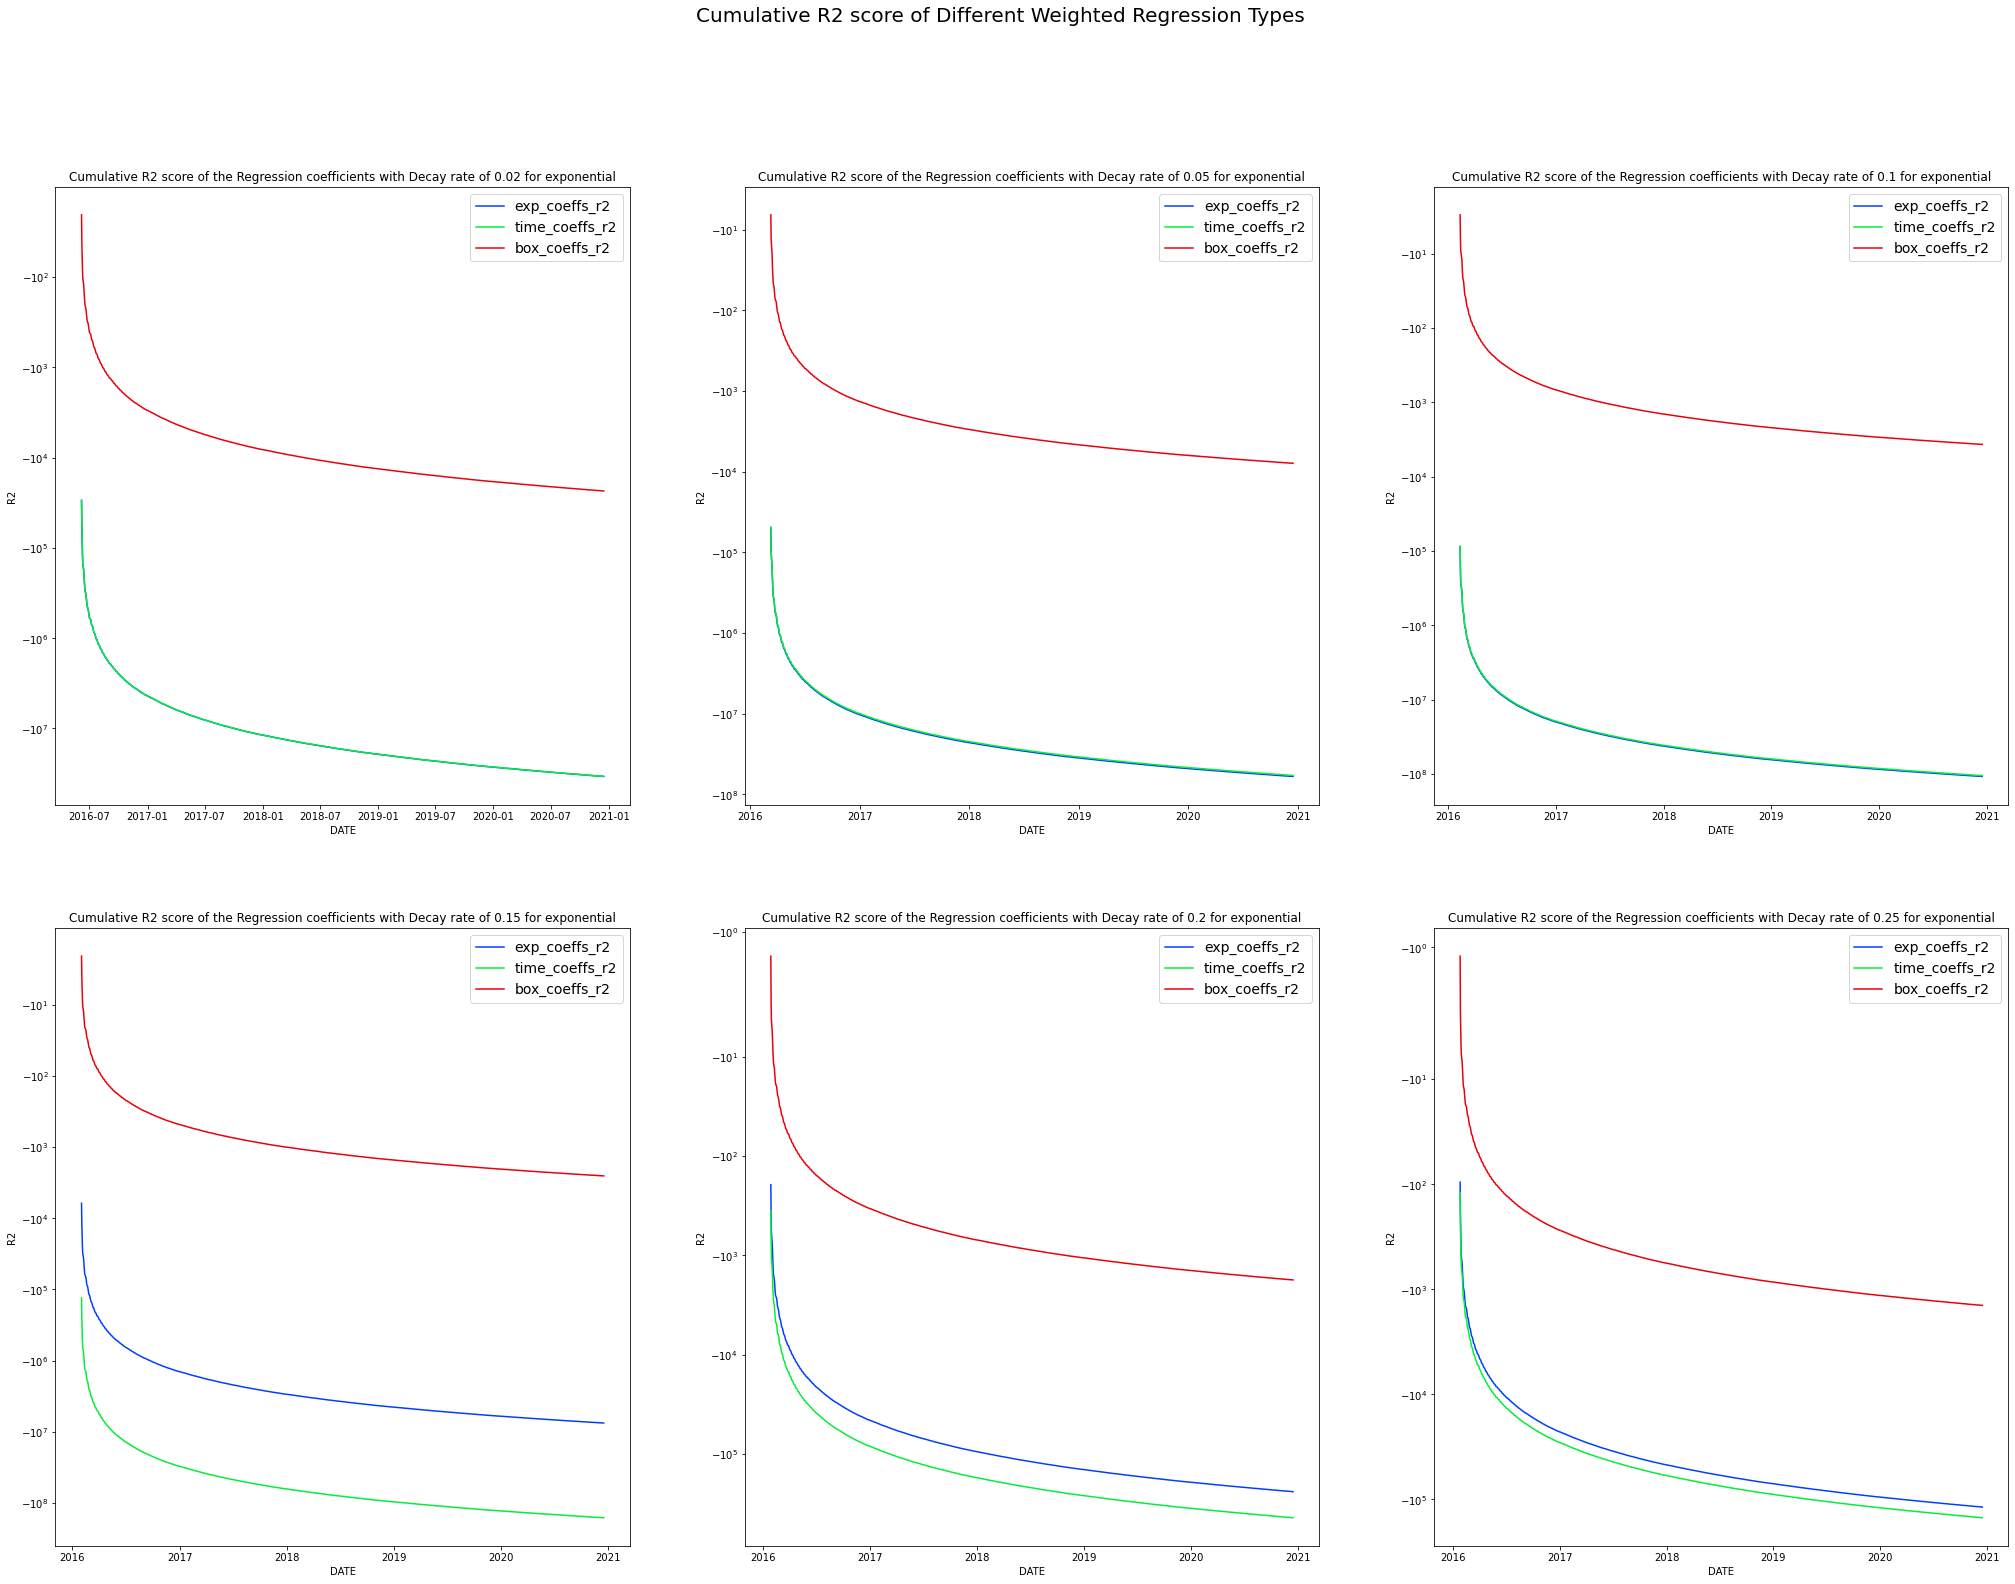

In [22]:
plot_r2_score_cumsum()

The first thing to notice about these plots is that the scaling is the negative log. What I have done here is for each of the ~400 factors I have computed the $R^2$ of it's coefficient versus the target coefficients from the out-of-sample $\beta$ coefficients then I took the cumulative sum to see how the $R^2$ evolves over time for the different regression techniques. The three types of regression techniques employed in this notebook are the following:

* Box-Regression with a fixed window based on the decay rate $\lambda$.
* Exponential Regression where the weights are the power of $(1-\lambda)^x$ such that $x \in \mathbb{N}\cup\{0\}$
* Time Exponential Regression where the weights come from $e^{-\lambda t}$ where $t=1$ is one day. 

From these plots, we can gather that all of them are negative. This makes sense since for each date we are computing the coefficients of 400 different betas and we are comparing each regression techniques to a small-windowed small box regression, we would expect the small-windowed regression coefficients to vary widly. Having so many $\beta$ we also have very small values for each and a small absolute change in their values results in a relatively big change in the $R^2$.

The second is that in-sample box regression coefficients $R^2$ is drastically superior than the exponential regressions. I think a good explanation for it is because like the out-of-sample box regression, the in-sample box regression is a similar model and behaves similarly. As for the exponential regressions, the $\beta$'s don't move as much so they are poor predictions of future box-regressions $\beta$'s. The difference is big enough that in order to achieve some sense of comparaison in the plots, I had to change the scale to base 10 $\log$. 

The third observation is that as the decay rate is increasing, the better the $R^2$ score are in terms of predicting the $\beta$. Again, this makes sense because as the decay-rate increase, our regression techniques get closer and closer to a small-windowed regression which mimicks the out-of-sample regressions coefficients.  

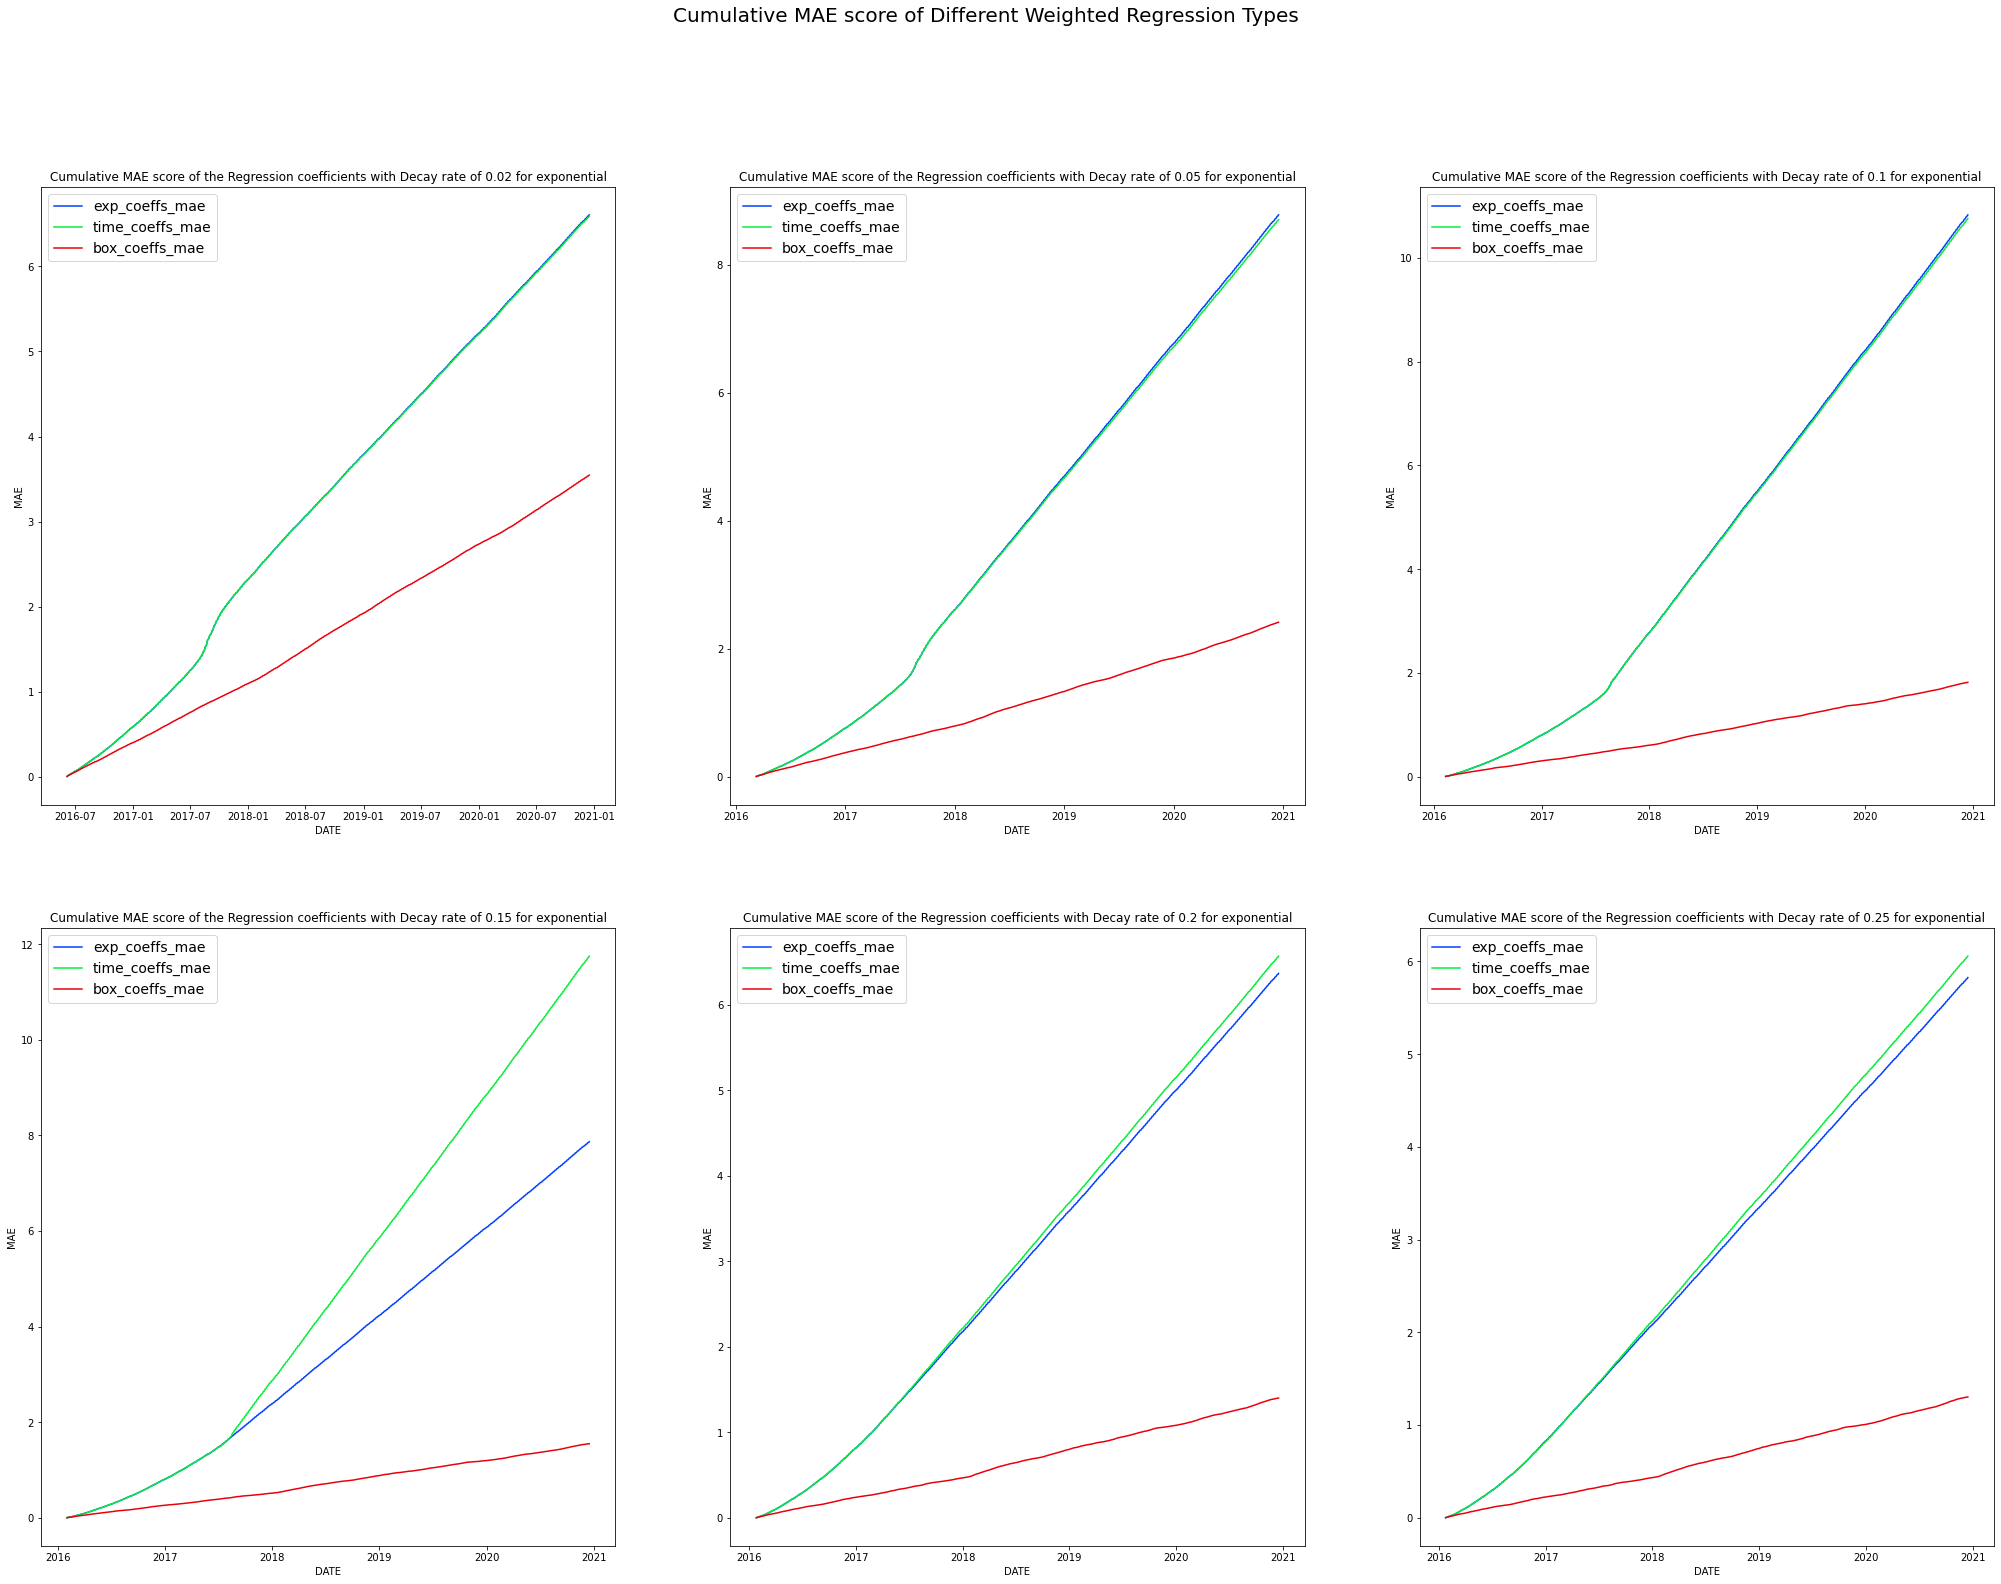

In [23]:
plot_r2_score_cumsum(mae_=True)

In these plots, we are doing the same thing as the previous one but instead of looking at the cumulative $R^2$, we are looking at the cumulative MAE difference of the coefficients over time. We can observe the same narative in comparing the exponential regressions versus the box regression, where the box regression MAE score is better than the exponential ones. Unlike the $R^2$ though, as the decay rate increases, it is not true that MAE improves. If we look at the first plot where $\lambda = 0.02$, we have an increase in the scoring for the exponential regressions when $\lambda = 0.05, 0.10, 0.15$ but by the last values, the MAE improves. The Box-Regression MAE score does improve as $\lambda$ increases. So far, it looks like the box-regression is better at predicting future target $\beta$'s. 

Doing a multi $\beta$ regression with so many tickers like I did is an attempt at mimicking the SPY index. Given that this is the goal, if one wants to replicate SPY, it does seem so far that one should be using a box regression technique to be closer to the near future $\beta$ coefficient. One issue one would encounter if trying to replicate the index would be if the $\beta$'s, or the weights, constantly change. One would need to rebalance often and would have to pay many transaction costs in rebalancing the portfolio.

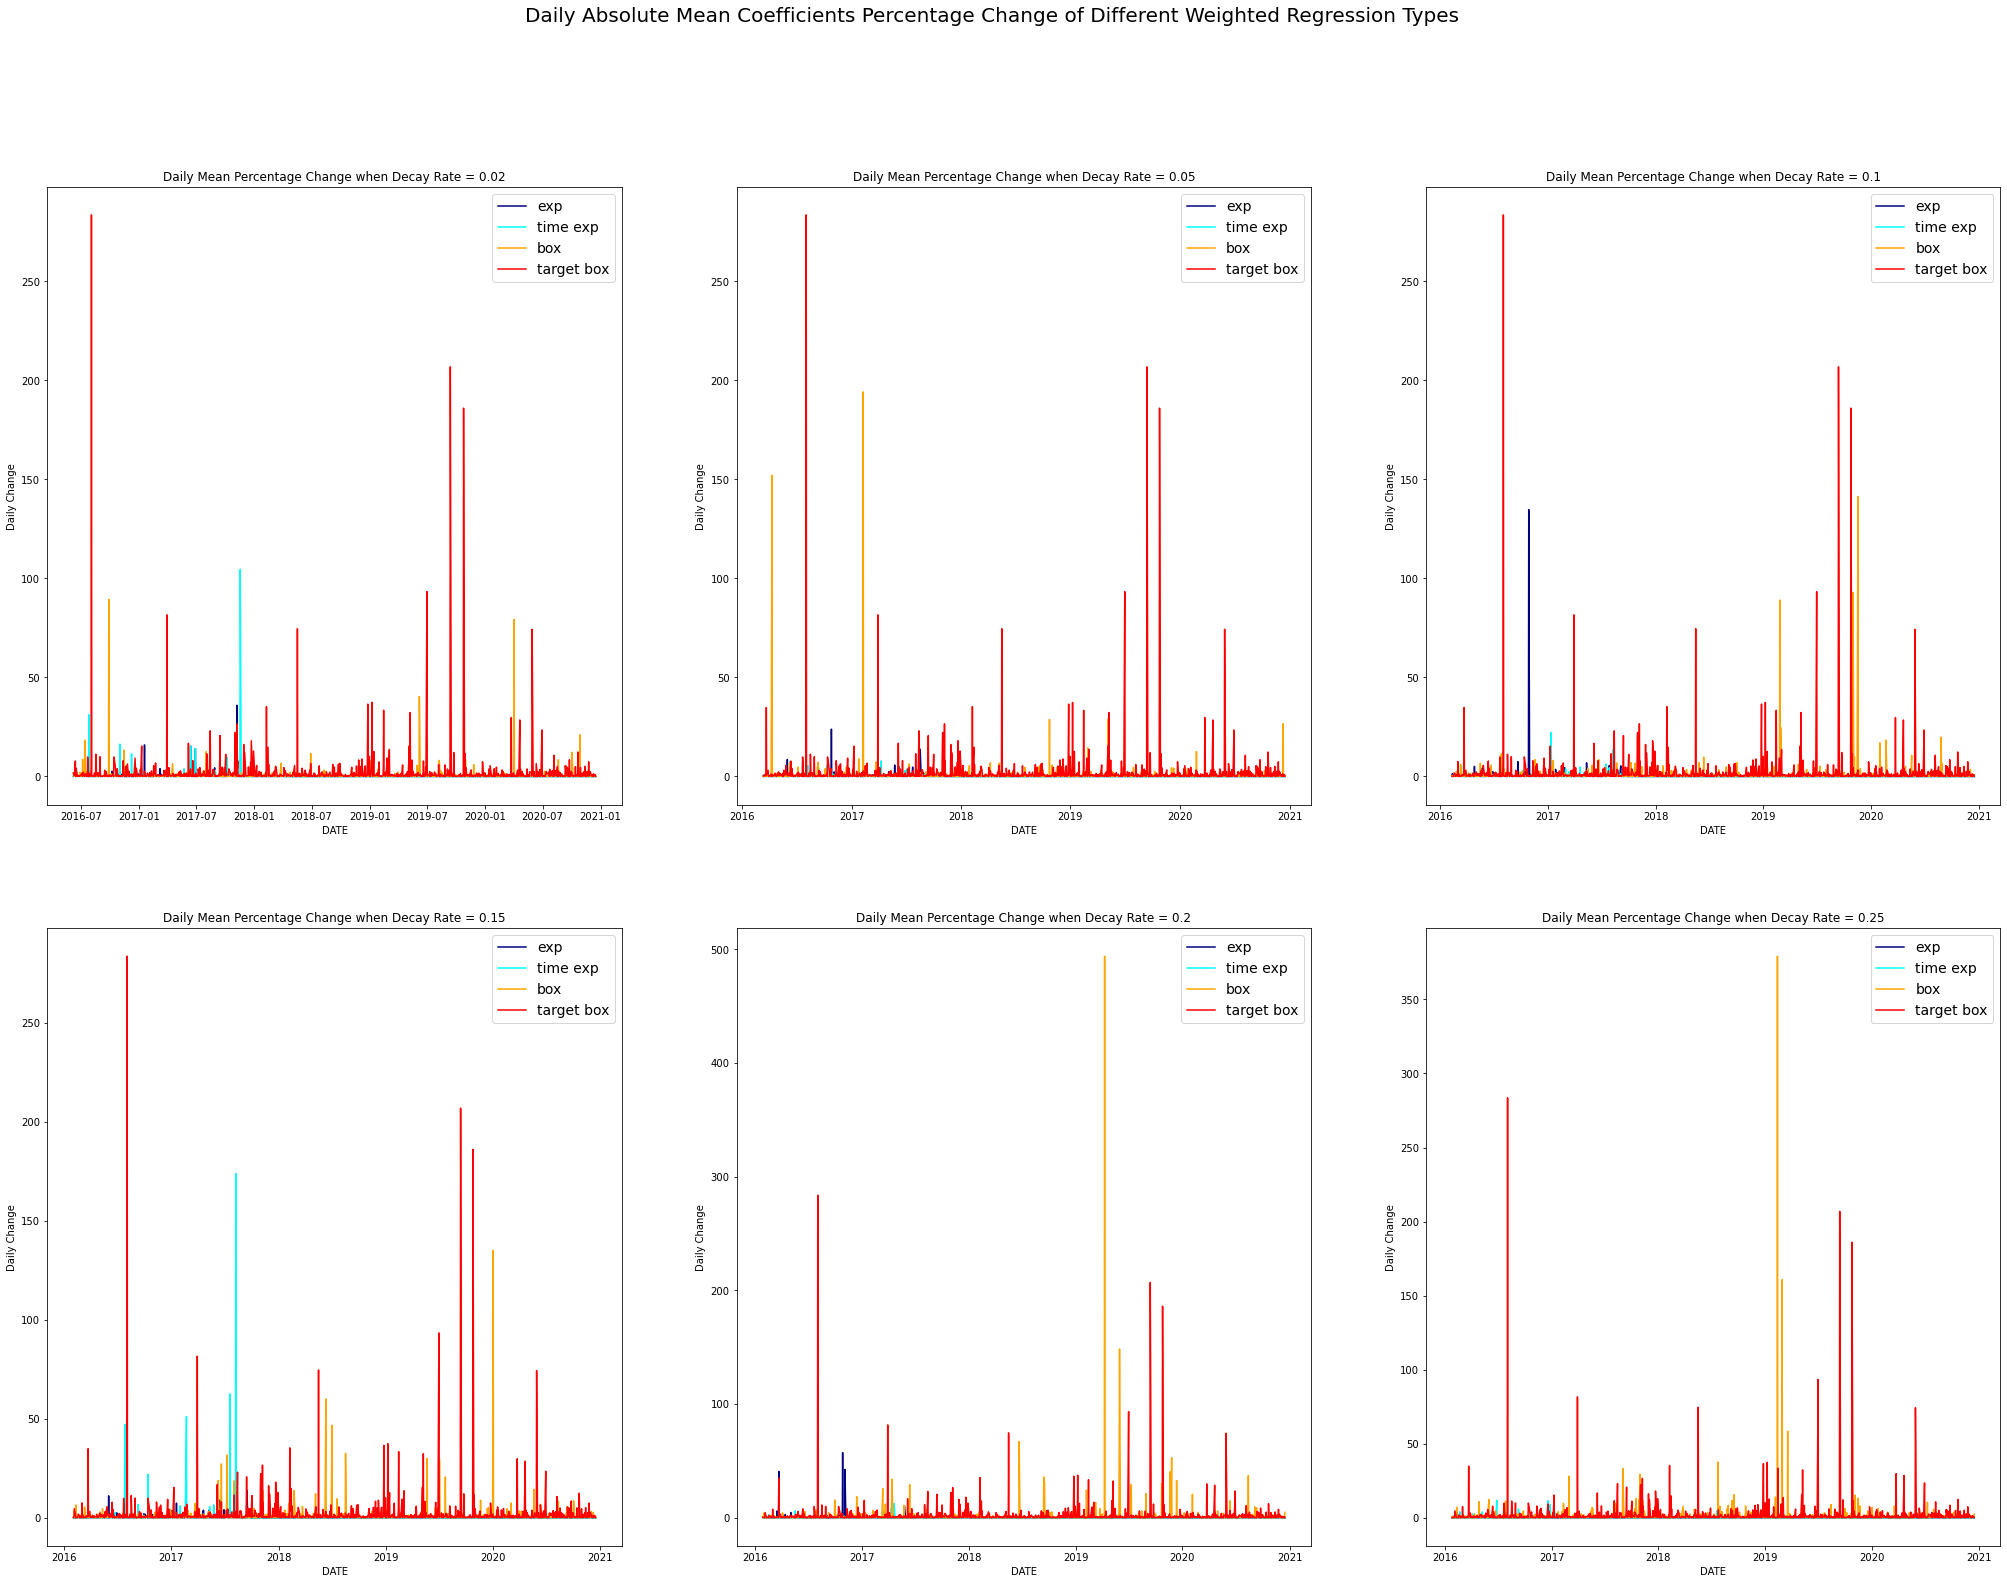

In [24]:
stats1, stats2 = plot_coefs_change_sum()

In these last plots we can observe the daily mean percentage change for each $\beta$. By comparing the percentage change of the $\beta$'s, in ways I have normalized the coefficients,I have removed some few outliers to be able to observe the general trend. I have colored the box regressions with warm colors and the exponential regressions with cold colors in order to observe how much more the box regressions coefficients are changing compared to the exponential regressions. The exponential regressions coefficients vary more at the beginning but with time, they start to converge and barely move. This is extremely useful if one wants to build a portfolio to replicate SPY without spending time, energy and transaction costs rebalancing all the time. They do seem to show more stability. 

In [25]:
stats1

,Exponential-0.02,Time-Expo-0.02,Box-0.02,Target-0.02,Exponential-0.05,Time-Expo-0.05,Box-0.05,Target-0.05,Exponential-0.1,Time-Expo-0.1,Box-0.1,Target-0.1
Mean,0.154659,0.255752,0.567594,2.531036,0.123921,0.106464,0.757536,2.489774,0.217259,0.124861,0.863443,2.469247
Median,0.000375,0.00015,0.106584,0.498226,0.000002,0.000001,0.126124,0.506615,0.0,0.0,0.162103,0.501834
Std Dev,1.35836,3.362255,3.946495,13.555547,0.904355,0.523779,7.316962,13.282643,3.887956,0.857204,5.686911,13.196991
1st Quartile,0.000001,0.000001,0.039731,0.1797,0.0,0.0,0.040953,0.188464,0.0,0.0,0.052707,0.182926
3rd Quartile,0.033415,0.03334,0.259207,1.28095,0.026763,0.028491,0.31893,1.281352,0.027805,0.028034,0.427288,1.277475
Skew,19.770521,27.170175,18.229414,14.807679,19.258029,10.726143,22.963857,15.040505,34.012548,18.19921,19.101081,15.136086
Kurtosis,460.309044,817.342484,372.144213,256.046899,447.323328,135.490587,558.302772,265.343756,1173.979236,410.478545,407.390277,268.810606


In [26]:
stats2

,Exponential-0.15,Time-Expo-0.15,Box-0.15,Target-0.15,Exponential-0.2,Time-Expo-0.2,Box-0.2,Target-0.2,Exponential-0.25,Time-Expo-0.25,Box-0.25,Target-0.25
Mean,0.134087,0.402093,0.953349,2.462076,0.176668,0.080785,1.612677,2.457973,0.041623,0.08739,1.402691,2.453827
Median,0.0,0.0,0.223385,0.50377,0.0,0.0,0.255566,0.501834,0.0,0.0,0.284905,0.500419
Std Dev,0.756426,5.695791,5.038063,13.162935,2.371373,0.531659,15.317995,13.151717,0.190662,0.642045,12.181335,13.140539
1st Quartile,0.0,0.0,0.07945,0.181841,0.0,0.0,0.091968,0.180763,0.0,0.0,0.102922,0.1797
3rd Quartile,0.028258,0.028963,0.567623,1.27133,0.003063,0.010438,0.640077,1.265779,0.0,0.000064,0.724342,1.260821
Skew,11.431744,25.165865,18.430619,15.174823,20.100524,15.554517,28.195439,15.187838,9.080999,13.387951,26.740689,15.200821
Kurtosis,158.482421,718.560657,435.837316,270.214539,422.036576,295.080456,881.968206,270.684168,109.529254,207.2366,789.402615,271.153231


As I mentioned, they are a few outliers and looking at higher moments statistics really doesn't give us much information. We can observe how big the mean is verus the median, this is because of the few outliers that skew the entire distribution as we can observe in the Skew part of the statistics. It is difficult to interpret anything from these statistics given the wild behaviors of the coefficients, the outliers and the scale of them. 

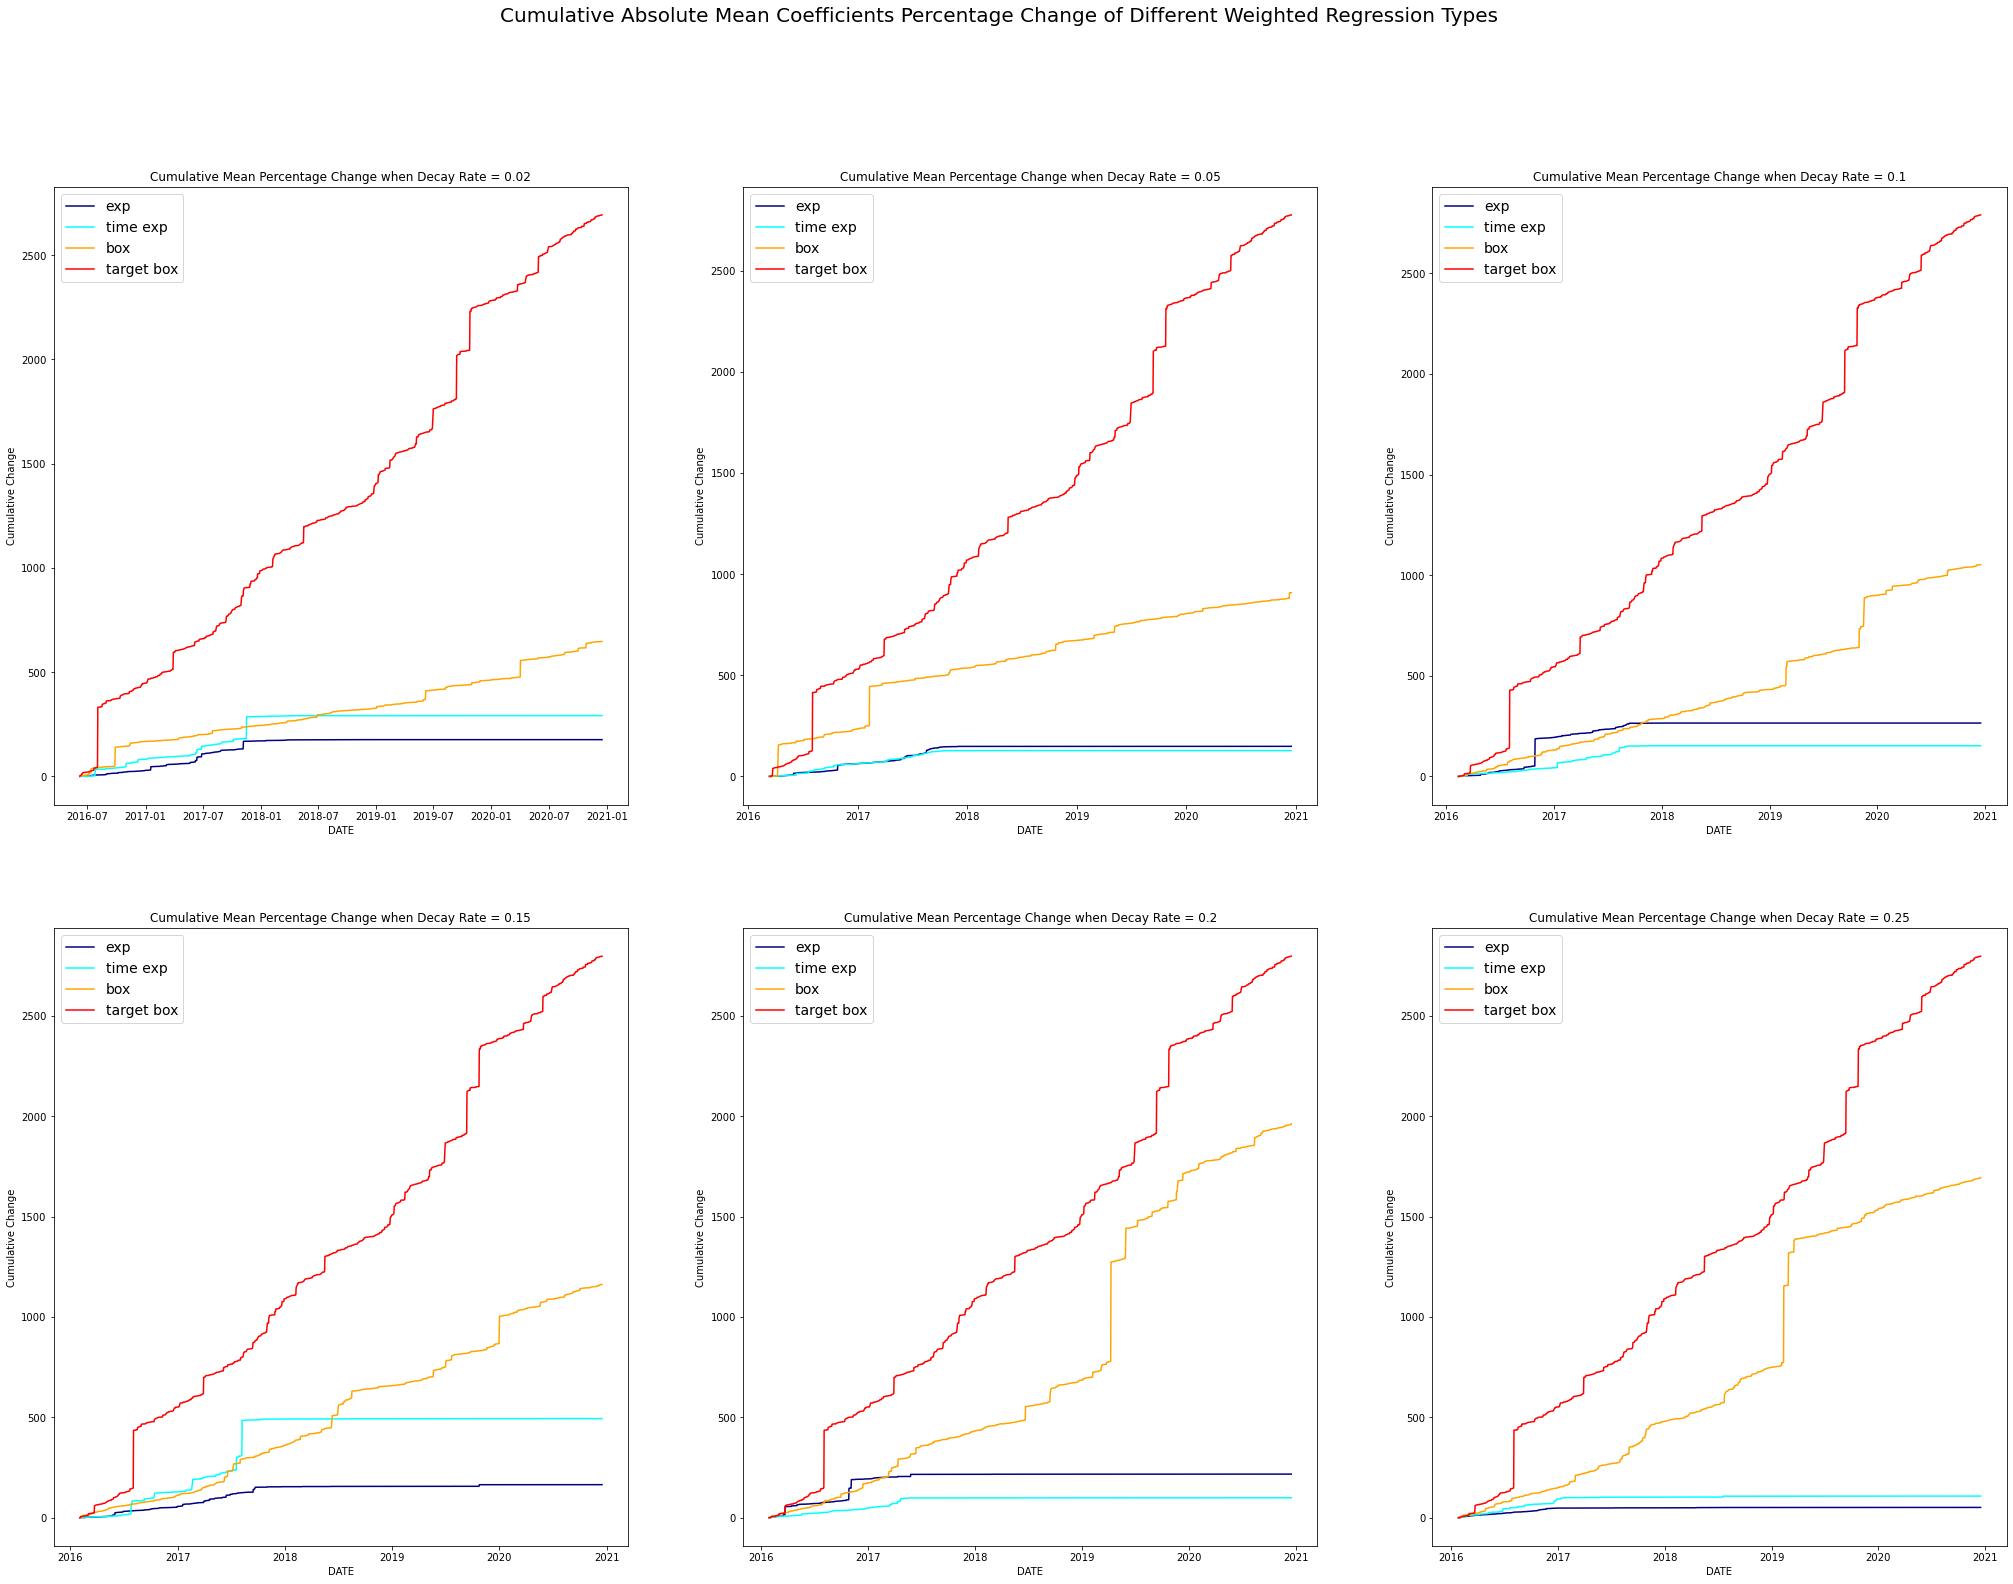

In [27]:
plot_coefs_change_cumsum()

In this plot, I have ploted the cumulative daily mean percentage change for all the regression techniques. We can clearly see the stability of the exponential regressions which converges rapidly and stop changing after a certain time in 2017. As for the box regression, the smaller the decay rate, or the higher the regression window, the more stable it is which intuitively makes sense. I found it very interesting how the first 2 set of plots seems to indicate that the box regression might indiciate better performance and how these last 2 set of plots while not speaking of performance indicate a lot more stability from the exponential regression. If the goal is to replicate SPY than that stability is valuable. 

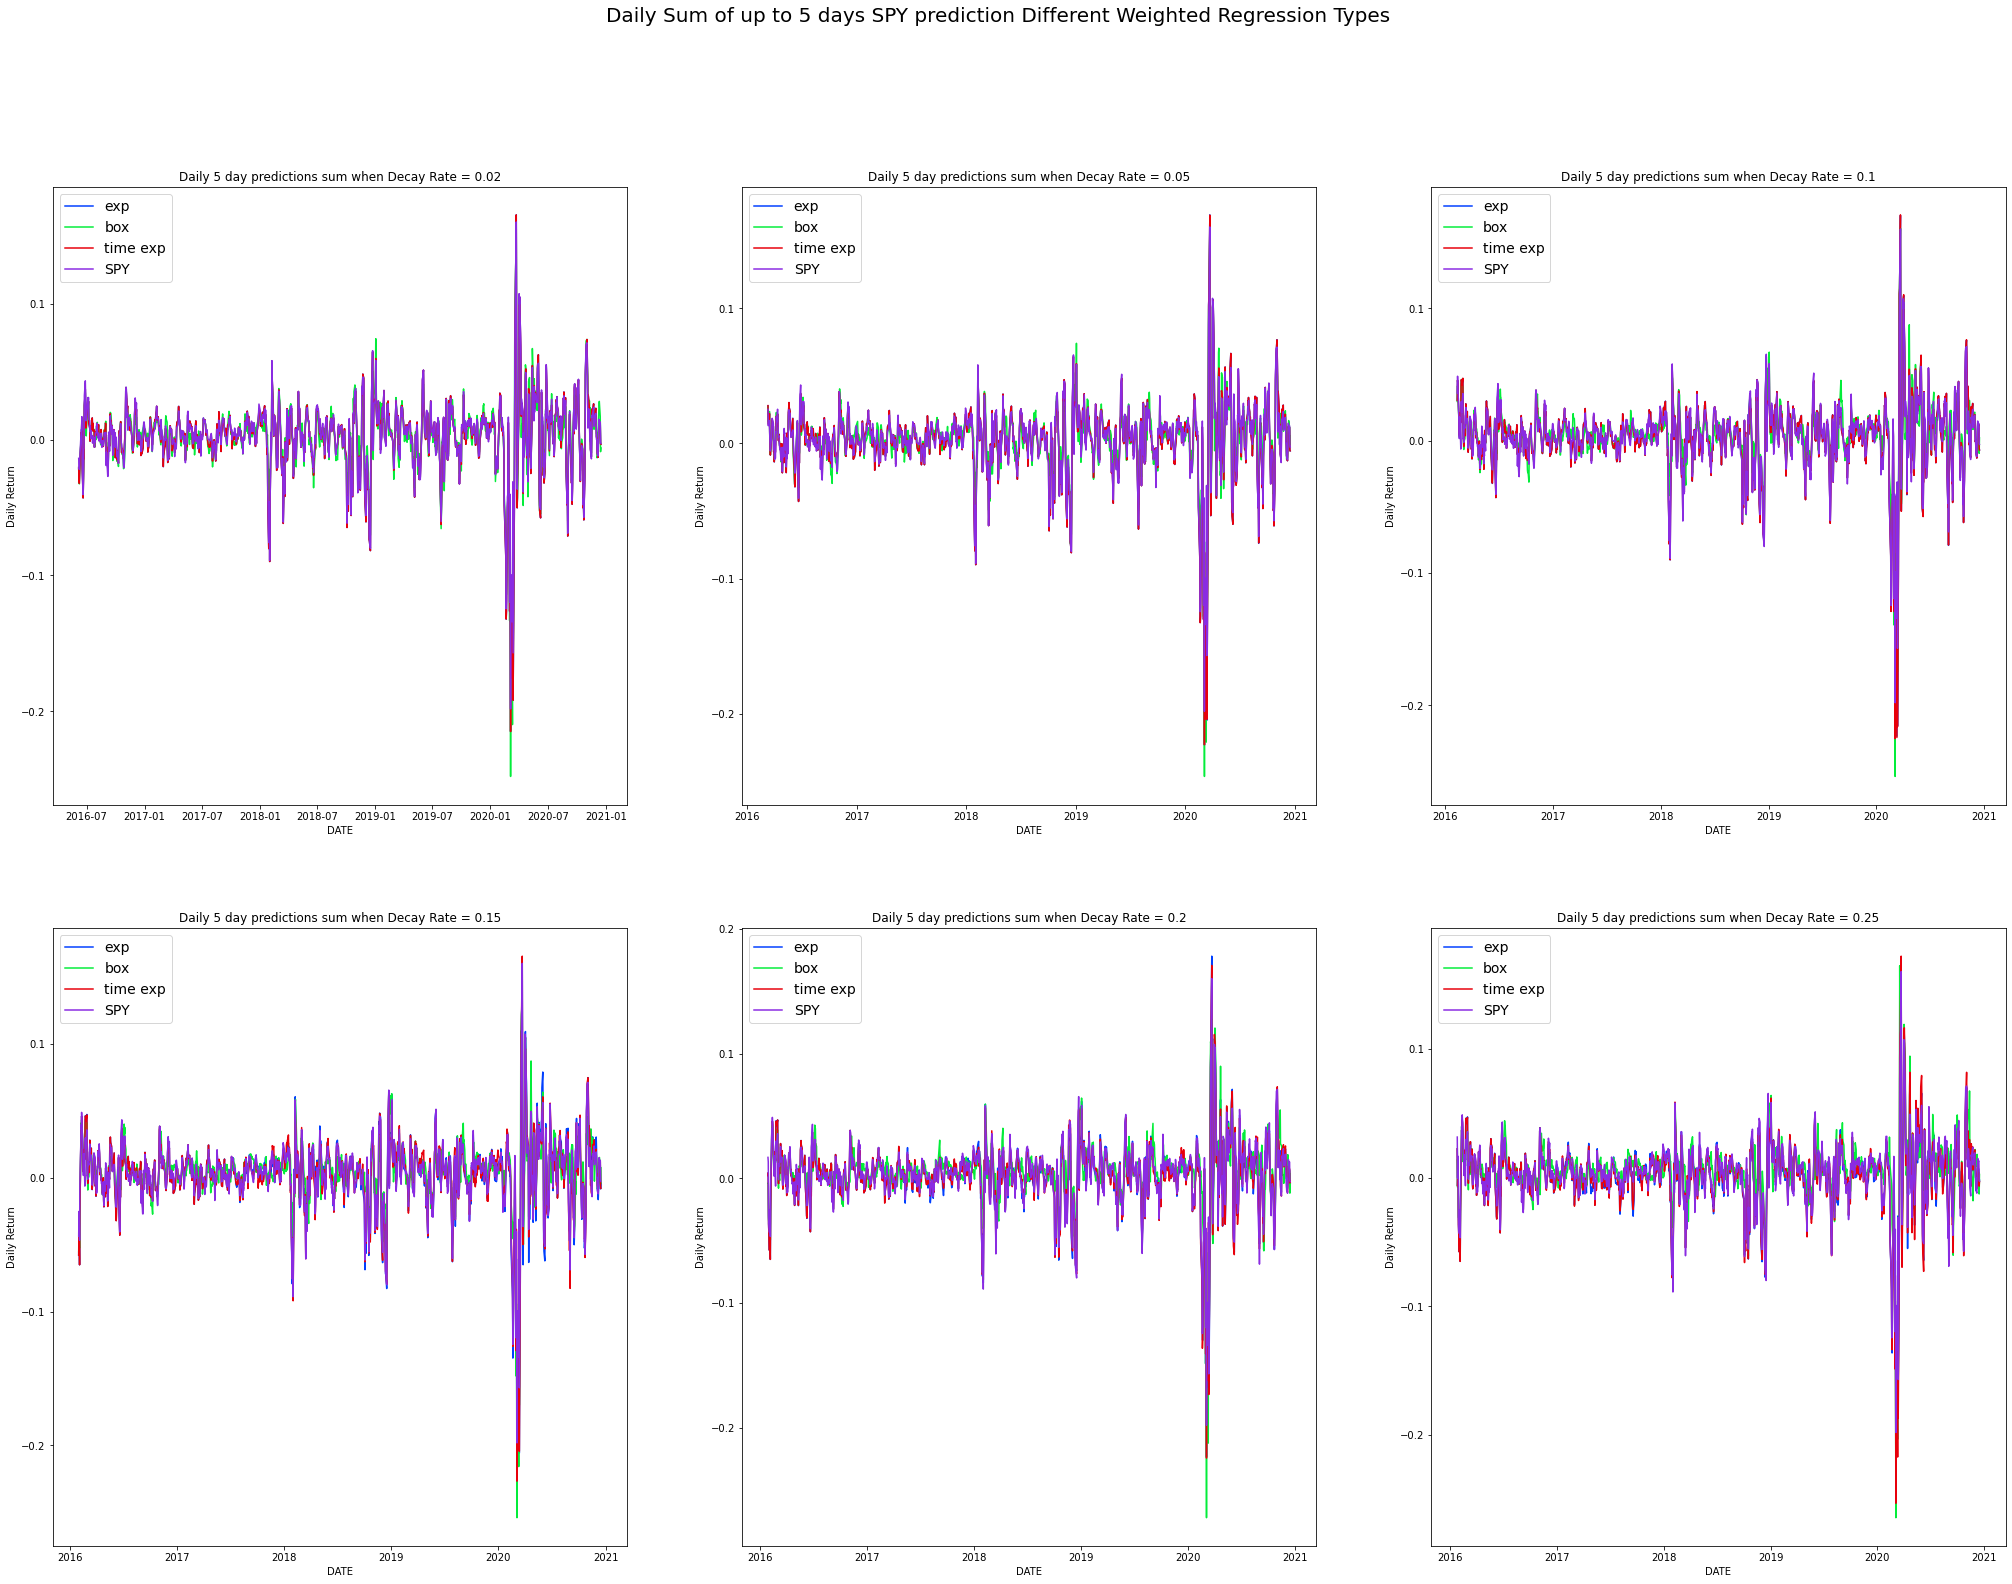

In [28]:
plot_prediction()

In the plot above, we have the daily mean of the 5 forward predictions from one day to five days. This doesn't really tell much in terms of comparaison but we can notice how the behavior becomes extremely hectic around the COVID-19 pandemic news. 

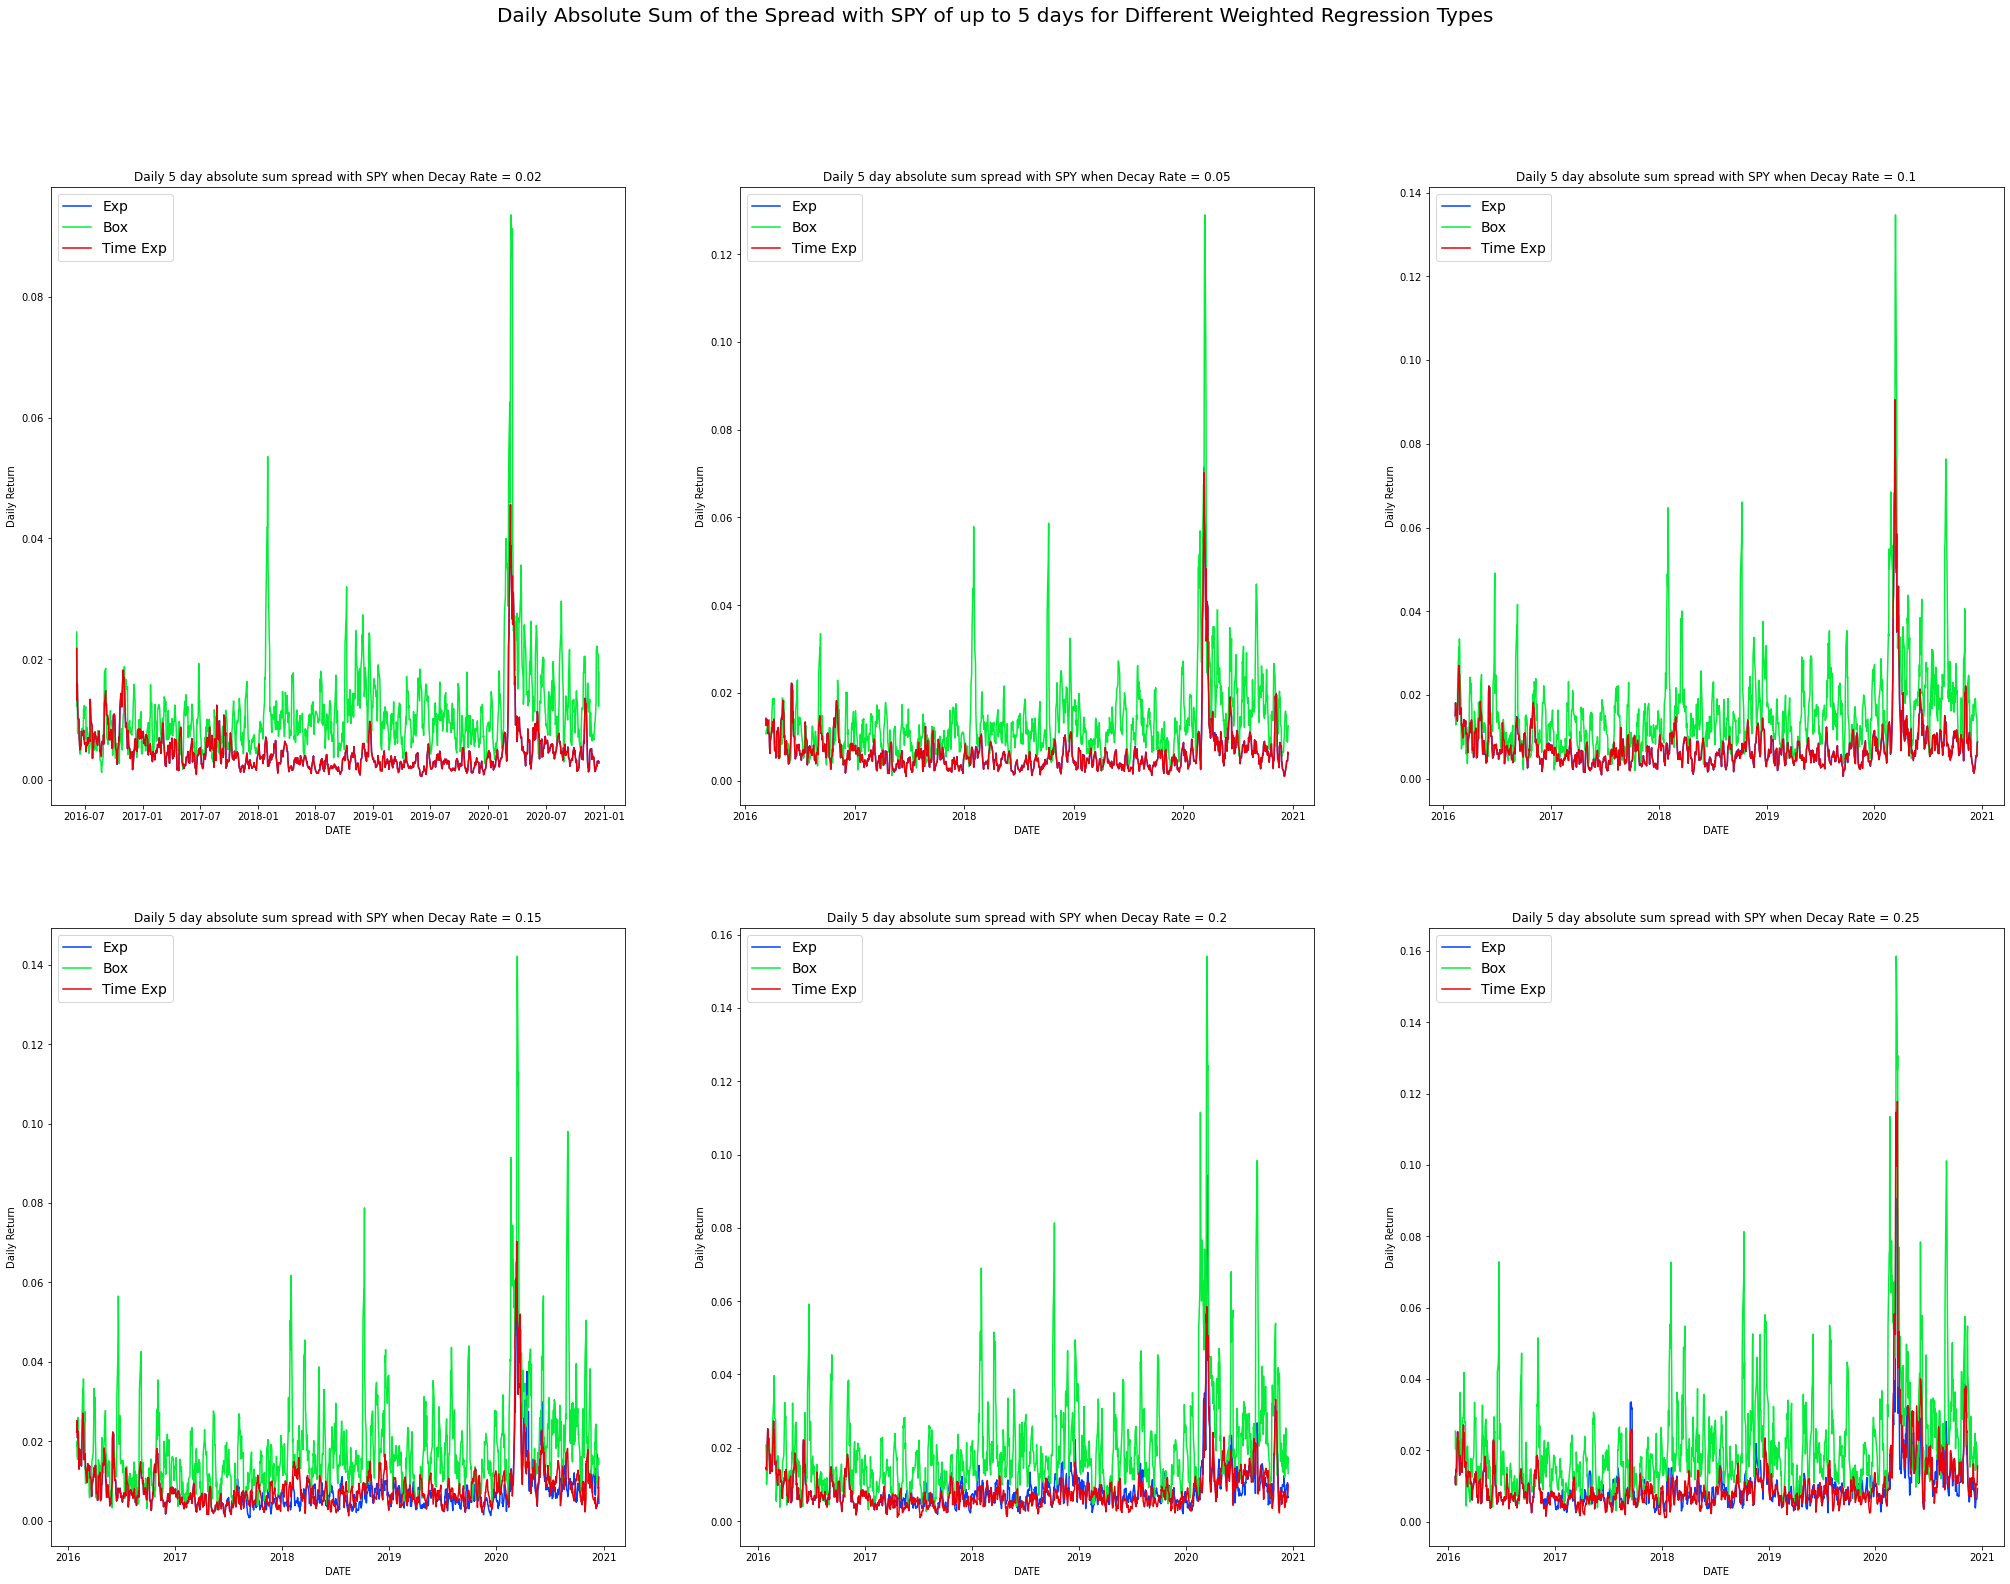

In [29]:
stats1, stats2 = plot_abs_spread_prediction()

This is somewhat similar plot as last one but much more telling. In this one I have computed the daily mean absolute spread for the five day predictions. In other words, for each regression technique and for each day, I compute the absolute spread of the 1 to 5 days predictions versus the target. I use the coefficients from the regression to compute the forward predicted values up to 5 days and compared how much they differed. A good model would have a lower spread. We can see that across the different plots, there does seem to have a higher spread for the box regression than the exponential regressions. This would lead us to believe that the exponential regressions are more robust than the box regression in computing the SPY returns based on the change of returns of the regressors. 

In [30]:
stats1

,Exponential-0.02,Time-Expo-0.02,Box-0.02,Exponential-0.05,Time-Expo-0.05,Box-0.05,Exponential-0.1,Time-Expo-0.1,Box-0.1
Mean,0.004713,0.004704,0.011258,0.006391,0.006339,0.013514,0.007725,0.007701,0.016101
Median,0.003813,0.003801,0.009595,0.005261,0.005212,0.011306,0.006451,0.006413,0.013638
Std Dev,0.00404,0.004035,0.008147,0.005474,0.005418,0.009987,0.006494,0.006546,0.011379
1st Quartile,0.002532,0.00251,0.006991,0.003757,0.003724,0.008256,0.00466,0.004626,0.009462
3rd Quartile,0.005666,0.005672,0.012786,0.007331,0.007276,0.015691,0.009097,0.009054,0.018905
Skew,4.648453,4.640049,4.773644,5.776389,5.702409,4.770639,6.20323,6.283253,3.598709
Kurtosis,32.176894,32.090023,35.99604,48.280978,47.142303,38.916431,56.327021,57.517276,22.498601


In [31]:
stats2

,Exponential-0.15,Time-Expo-0.15,Box-0.15,Exponential-0.2,Time-Expo-0.2,Box-0.2,Exponential-0.25,Time-Expo-0.25,Box-0.25
Mean,0.007674,0.008296,0.017978,0.008889,0.008211,0.019641,0.010154,0.010355,0.021248
Median,0.006376,0.007014,0.014813,0.007394,0.006769,0.015833,0.00827,0.007962,0.017218
Std Dev,0.005899,0.006027,0.013174,0.006614,0.005564,0.014438,0.007436,0.009415,0.015618
1st Quartile,0.004636,0.004963,0.010639,0.005466,0.005087,0.011383,0.006319,0.006019,0.012054
3rd Quartile,0.008655,0.009955,0.021352,0.010376,0.009608,0.023088,0.011725,0.011581,0.025245
Skew,4.005172,4.425172,3.465353,5.812496,3.604421,3.316083,5.246481,5.878129,3.165439
Kurtosis,23.472635,30.334101,19.705578,54.105859,21.611941,17.927697,45.118636,51.64603,16.201826


This time we are looking at a spread where the ideal goal would be to have a mean of 0 with as little volatility as possible. In most cases it does seem like the exponential regressions have less volatility and considering the early outliers pushing the kurtosis and skew, without them it is possible that the volatility across all regressions is better for exponential but it is not the case here. 

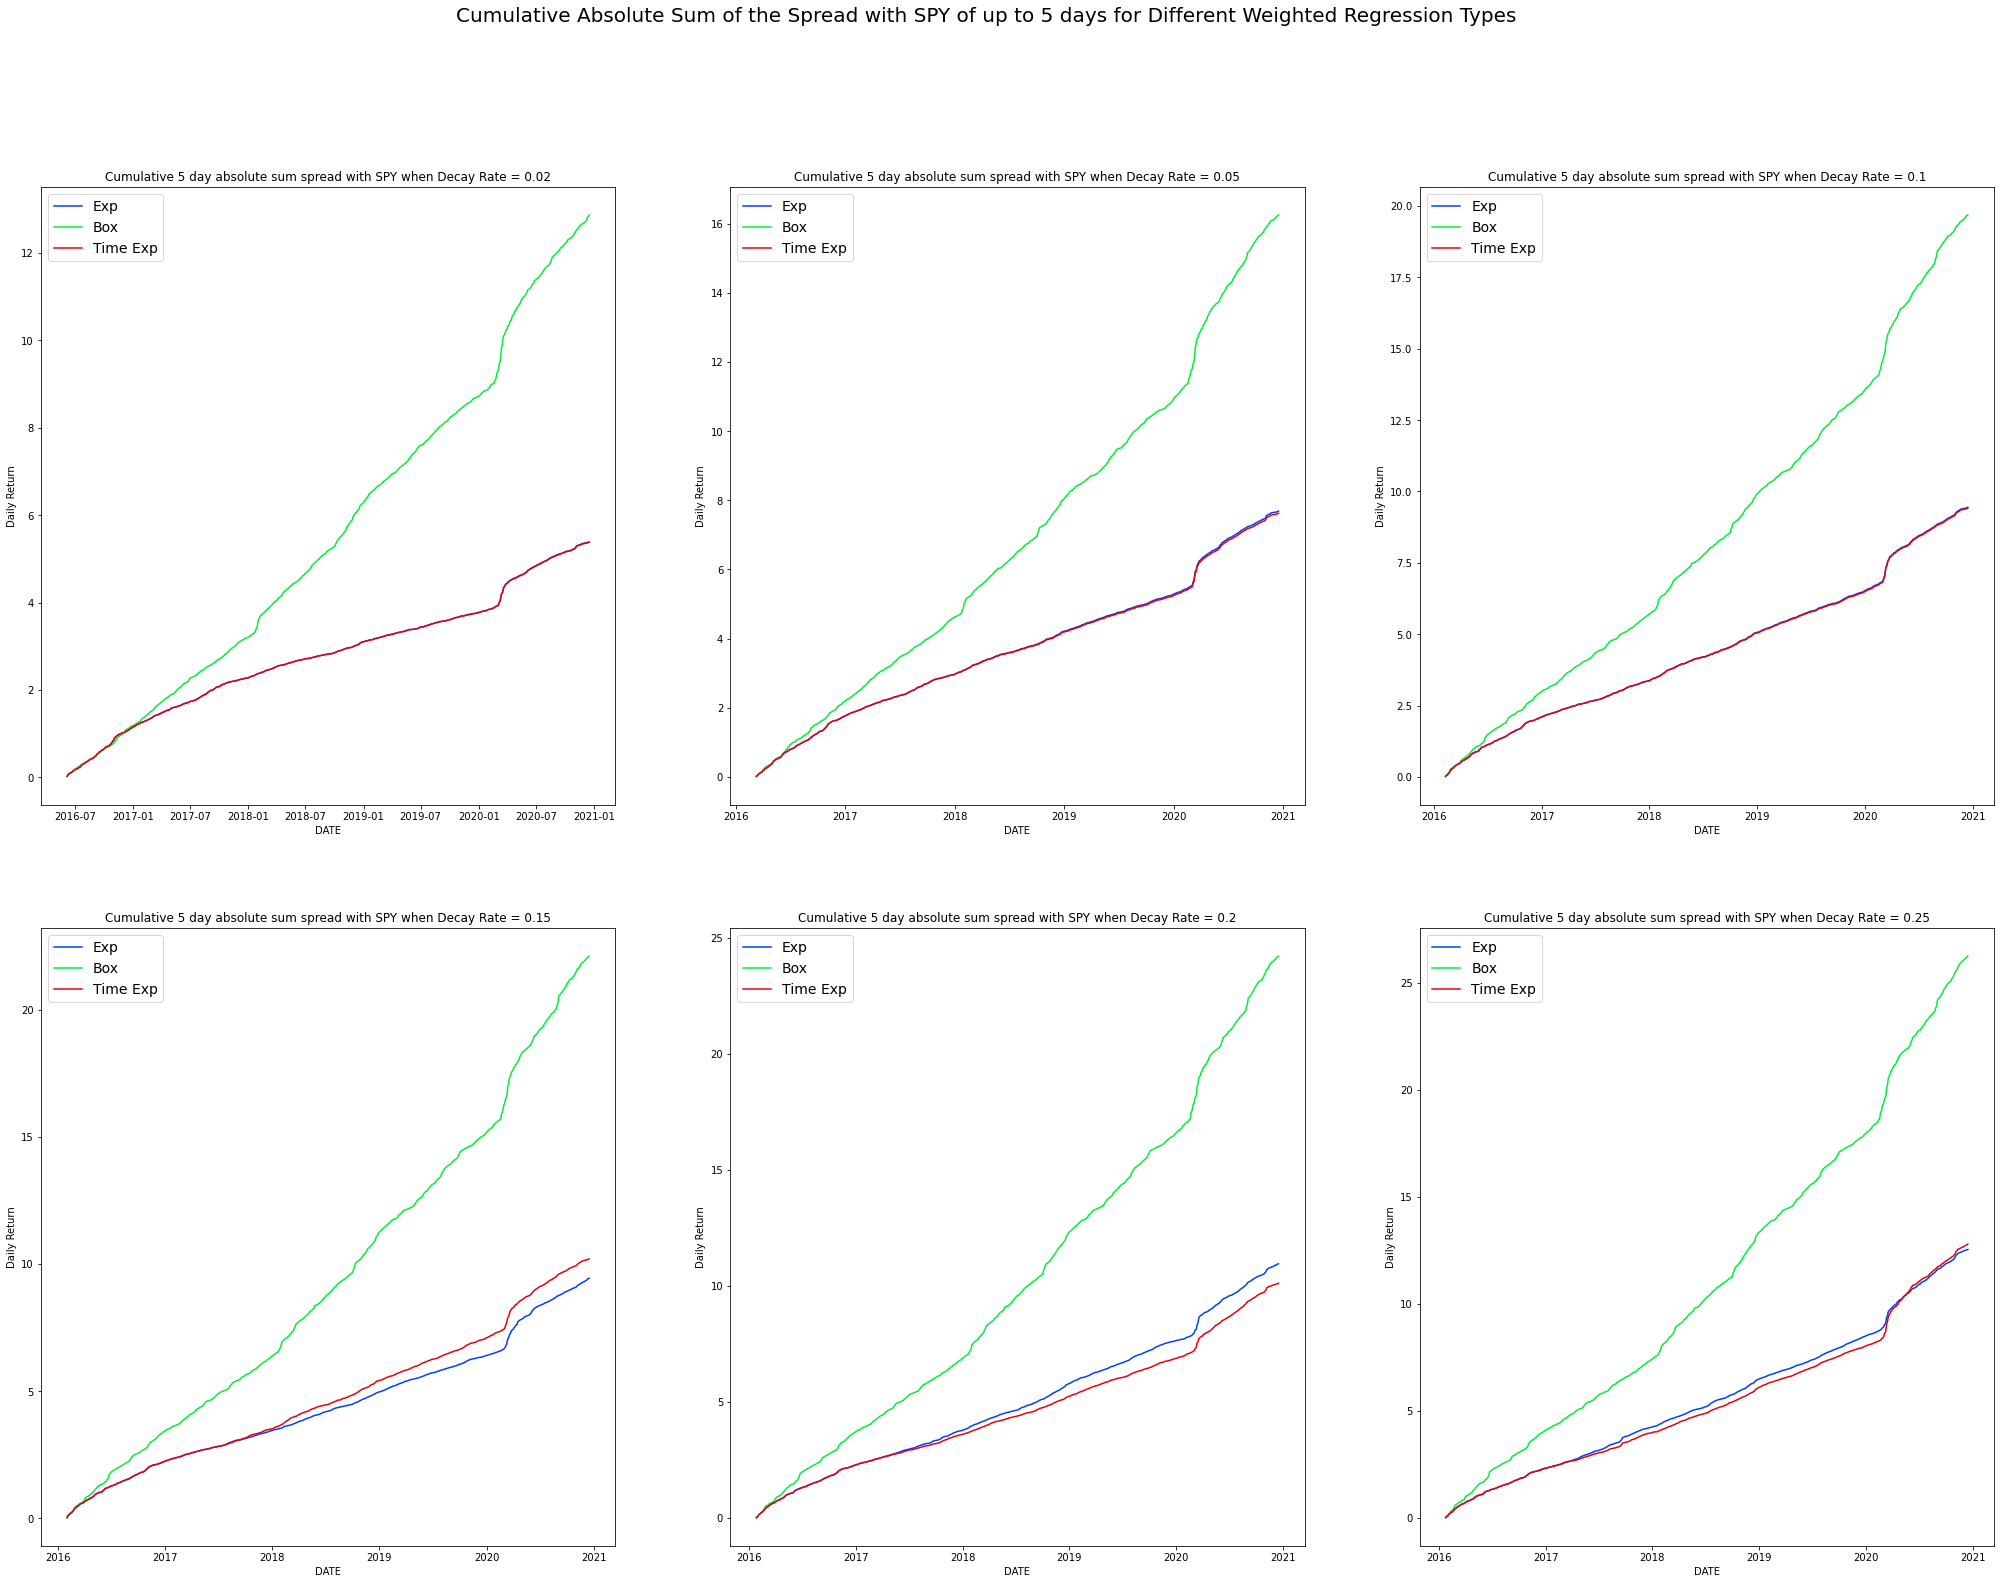

In [32]:
plot_cumsum_abs_spread_prediction()

In this last plot I have graphed the cumulative MAE spread between the regression techniques and SPY. It does look like the exponential regressions have a better, more stable and robust prediction where the cumulative error is less than box regression. Although, when $\lambda = 0.15$ all three regressions seem quite close to each other we can observe that when $\lambda$ is getting smaller, the cumulative errors tend to trend down which makes sense from smoothing out the weights further down. The increase of stability from a smaller lambda also materialize itself as more robust.   

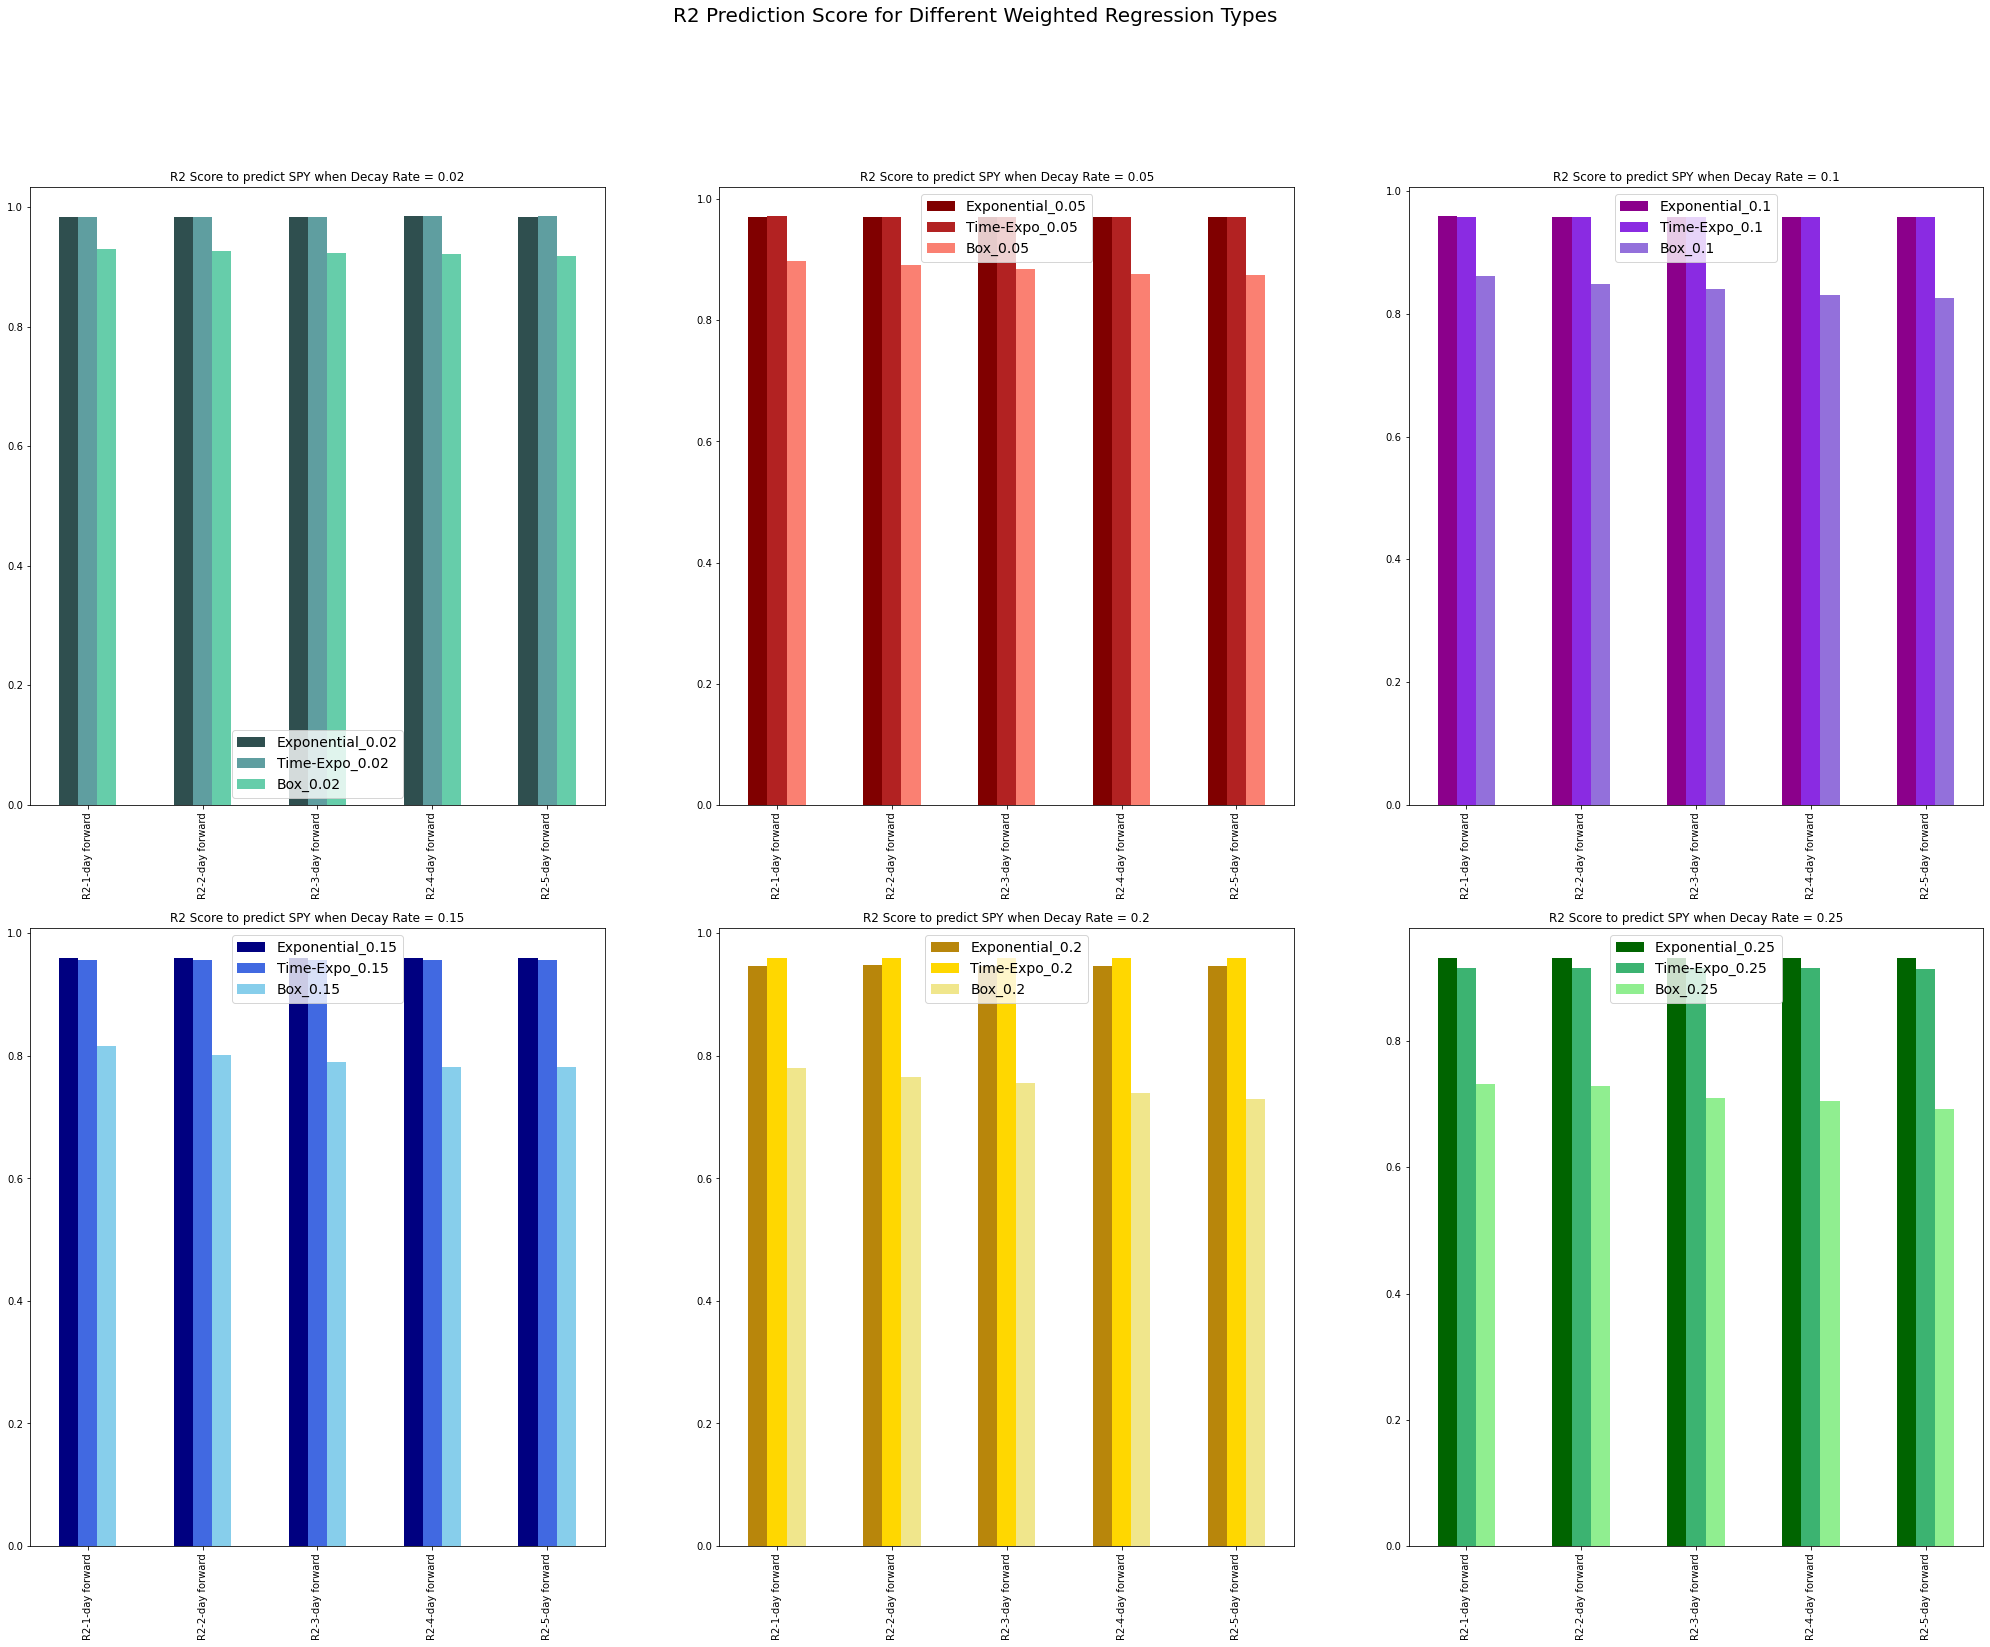

In [33]:
plot_bar_1()

In this bar plot, I look at comparing the different regression techniques among each other to see how they differ in evaluating one to five day forward SPY. For each value of $\lambda$, I look at the $R^2$ score of each regression technique for a 1 day to 5 day forward using the same $\beta$ coefficients. The exponential regressions seem much more robust than the box regression where other than $\lambda = 0.15$(again), they seem to outperform the box regression. We can definitely see that with $\lambda=0.20, 0.25$ where the exponential regressions seem fairly superior in their prediction of the SPY returns based on coefficients using prior data. 

In [34]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

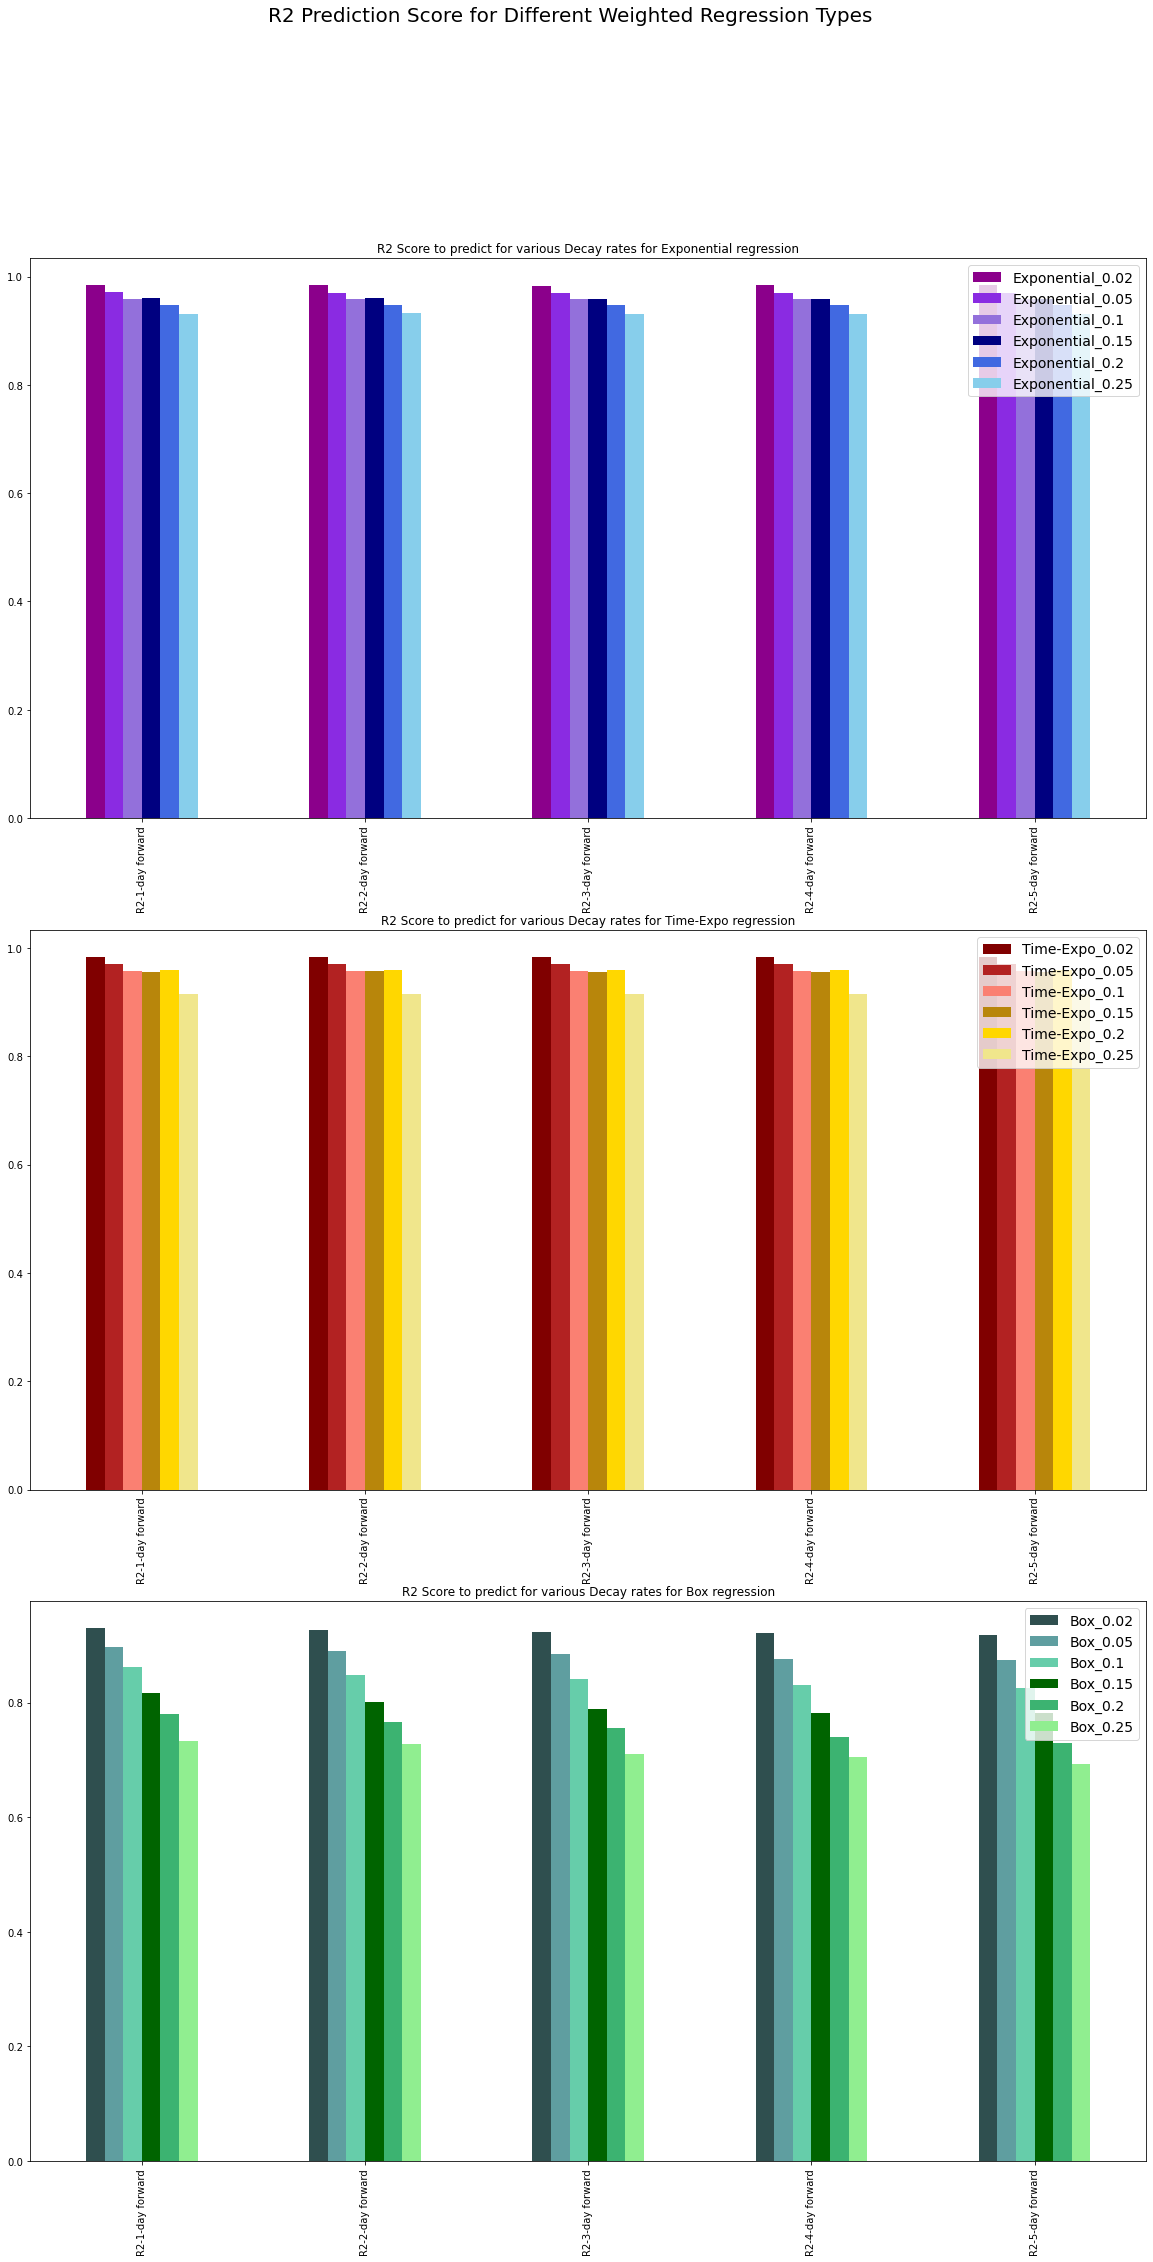

In [35]:
plot_bar_2()

In this last bar plot for a given regression technique, I look at how the decay factor affects the prediction error for each of the 5 predictions we computed. We can observe in the exponential regressions that again, the $\lambda = 0.15$ does seem to cause trouble for some reason, but beside that, the decay rate doesn't seem to be influencing much the predictive nature of the exponential regressions. As for the box regression, it is very clear that the smaller the window (higher the $\lambda$) the worse the forward prediction gets. 

# 4. Conclusion

From what I gathered, if we want to compare the coefficients and the coefficients alone, then the in-sample box regression matches the out-of-sample box regression better than the in-sample exponential regressions. But, what is the utility of having a good proxy of the coefficients if it leads to more transactions, higher costs, and worse performances? It is fair to say that there is some utility in replicating or being able to replicate an index. In this case, we use 400 stocks which is definitely more than we would need to get a good enough proxy to replicate the index. 

If the goal of the investor would be to select a sample of stocks and try to replicate an index from it, then we made a strong case that the exponential regressions may be more suitable than the box regression to achieve that goal. Indeed, with a more stable set of coefficients, the cost of rebalancing and the frequency of rebalancing can be greatly reduced. The same thing could be said if the goal was to hedge and we would short the stocks in order to be more beta neutral. On top of the stability of the coefficients and weights of the replicating/hedging portfolio, the exponential regressions did show more robustness in predicting forward values using in-sample coefficients. 

As I mentioned at the beginning of the notebook, I think the goal of the exercise was to compute a single beta factor model and observe how the instability of the box regression versus the smoothness of the exponential. While I wasn't able to show the sudden change of the coefficient, I think that I was able to extract similar information and more by looking at a multi-factor model. I also feel like it is more realistic to regress multiple stocks for an index than a single one and I was able to clearly show the difference in the regression technique for that setting.  
